In [119]:
# ==========================================
# LIBRARY IMPORTS - ORGANIZED AND CLEANED
# ==========================================

# Basic Data Processing
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch

# Machine Learning - Core
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import f_classif, chi2
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score)

# Statistical Analysis
from scipy import stats
from scipy.stats import chi2_contingency

# System & Utility
import pickle
import joblib
from datetime import datetime

# Visualization Settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [121]:

# Phase 0: Data Loading and Preprocessing
# =============================================================================

def load_and_preprocess_data(file_path='Sample120.csv'):
    """
    Load and preprocess data with proper data type handling
    """
    print("=== Phase 0: Data Loading and Preprocessing ===")
    
    # Load raw data
    df = pd.read_csv(file_path)
    print(f"Raw data shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Define column types explicitly
    boolean_columns = [
        'HasTopTierUniFounder', 'HasAdvancedDegreeFounder', 'HasTechnicalFounder',
        'HasBusinessEduFounder', 'HasFounderWithPriorEntrepreneurialExp',
        'HasStartupEmployeeExp', 'HasTopTierCompanyExpFounder', 
        'HasFounderWithDomainExp', 'HasFounderWithDeepResearchExp'
    ]
    
    categorical_columns = ['TeamEduFieldDiversity', 'TeamGenderDiversity']
    
    # Fix boolean column parsing issues
    print("\nFixing boolean columns:")
    for col in boolean_columns:
        if col in df.columns:
            original_type = df[col].dtype
            
            # Handle different boolean representations
            if df[col].dtype == 'object':
                # Map string representations to boolean
                bool_map = {
                    'TRUE': True, 'True': True, 'true': True, 'T': True, '1': True, 1: True,
                    'FALSE': False, 'False': False, 'false': False, 'F': False, '0': False, 0: False
                }
                df[col] = df[col].map(bool_map)
            
            # Convert to boolean
            df[col] = df[col].astype(bool)
            
            # Validate conversion
            true_count = df[col].sum()
            false_count = len(df) - true_count
            print(f"  {col}: {original_type} -> bool (True: {true_count}, False: {false_count})")
    
    # Validate target variable
    print(f"\nTarget variable validation:")
    print(f"FundingSuccess unique values: {sorted(df['FundingSuccess'].unique())}")
    print(f"FundingSuccess distribution: {df['FundingSuccess'].value_counts().sort_index().to_dict()}")
    
    # Check for missing values
    missing_summary = df.isnull().sum()
    if missing_summary.sum() > 0:
        print(f"\nMissing values found:")
        print(missing_summary[missing_summary > 0])
    else:
        print(f"\nNo missing values detected")
    
    # Basic data validation
    print(f"\nData validation summary:")
    print(f"Total companies: {len(df)}")
    print(f"Successful companies: {df['FundingSuccess'].sum()}")
    print(f"Failed companies: {len(df) - df['FundingSuccess'].sum()}")
    print(f"Success rate: {df['FundingSuccess'].mean()*100:.1f}%")
    
    return df

# =============================================================================
# Phase 1: Exploratory Data Analysis (EDA) - Fixed Version
# =============================================================================

def analyze_technical_founders_corrected(df):
    """
    Corrected analysis of technical founders - fixing the critical error
    """
    print("\n=== Technical Founders Analysis (Corrected) ===")
    
    # Separate successful and failed companies
    successful = df[df['FundingSuccess'] == 1]
    failed = df[df['FundingSuccess'] == 0]
    
    # Calculate technical founder statistics correctly
    success_with_tech = successful['HasTechnicalFounder'].sum()
    success_total = len(successful)
    success_tech_rate = (success_with_tech / success_total) * 100
    
    fail_with_tech = failed['HasTechnicalFounder'].sum()
    fail_total = len(failed)
    fail_tech_rate = (fail_with_tech / fail_total) * 100
    
    print(f"Successful companies with technical founders: {success_with_tech}/{success_total} = {success_tech_rate:.1f}%")
    print(f"Failed companies with technical founders: {fail_with_tech}/{fail_total} = {fail_tech_rate:.1f}%")
    
    # Statistical significance test
    contingency_table = pd.crosstab(df['FundingSuccess'], df['HasTechnicalFounder'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\nContingency Table:")
    print(contingency_table)
    print(f"Chi-square test: chi2 = {chi2:.3f}, p-value = {p_value:.4f}")
    
    # Calculate impact metrics
    tech_success_rate = df[df['HasTechnicalFounder'] == True]['FundingSuccess'].mean() * 100
    non_tech_success_rate = df[df['HasTechnicalFounder'] == False]['FundingSuccess'].mean() * 100
    improvement = tech_success_rate - non_tech_success_rate
    
    print(f"\nSuccess rates by technical founder presence:")
    print(f"With technical founder: {tech_success_rate:.1f}%")
    print(f"Without technical founder: {non_tech_success_rate:.1f}%")
    print(f"Improvement: {improvement:.1f} percentage points")
    
    return {
        'success_tech_rate': success_tech_rate,
        'fail_tech_rate': fail_tech_rate,
        'chi2': chi2,
        'p_value': p_value,
        'improvement': improvement
    }

def analyze_domain_experience_corrected(df):
    """
    Corrected analysis of domain experience - fixing the critical error
    """
    print("\n=== Domain Experience Analysis (Corrected) ===")
    
    # Separate successful and failed companies
    successful = df[df['FundingSuccess'] == 1]
    failed = df[df['FundingSuccess'] == 0]
    
    # Calculate domain experience statistics correctly
    success_with_domain = successful['HasFounderWithDomainExp'].sum()
    success_total = len(successful)
    success_domain_rate = (success_with_domain / success_total) * 100
    
    fail_with_domain = failed['HasFounderWithDomainExp'].sum()
    fail_total = len(failed)
    fail_domain_rate = (fail_with_domain / fail_total) * 100
    
    print(f"Successful companies with domain experience: {success_with_domain}/{success_total} = {success_domain_rate:.1f}%")
    print(f"Failed companies with domain experience: {fail_with_domain}/{fail_total} = {fail_domain_rate:.1f}%")
    
    # This reveals the critical issue: failed companies actually have MORE domain experience
    if fail_domain_rate > success_domain_rate:
        print(f"\nCRITICAL FINDING: Failed companies have {fail_domain_rate - success_domain_rate:.1f} percentage points MORE domain experience!")
        print("This contradicts the original report's core assumption.")
    
    # Statistical significance test
    contingency_table = pd.crosstab(df['FundingSuccess'], df['HasFounderWithDomainExp'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\nContingency Table:")
    print(contingency_table)
    print(f"Chi-square test: chi2 = {chi2:.3f}, p-value = {p_value:.4f}")
    
    # Calculate actual impact metrics
    domain_success_rate = df[df['HasFounderWithDomainExp'] == True]['FundingSuccess'].mean() * 100
    non_domain_success_rate = df[df['HasFounderWithDomainExp'] == False]['FundingSuccess'].mean() * 100
    actual_impact = domain_success_rate - non_domain_success_rate
    
    print(f"\nActual success rates by domain experience:")
    print(f"With domain experience: {domain_success_rate:.1f}%")
    print(f"Without domain experience: {non_domain_success_rate:.1f}%")
    print(f"Actual impact: {actual_impact:.1f} percentage points")
    
    return {
        'success_domain_rate': success_domain_rate,
        'fail_domain_rate': fail_domain_rate,
        'chi2': chi2,
        'p_value': p_value,
        'actual_impact': actual_impact
    }

def analyze_team_size_corrected(df):
    """
    Corrected team size analysis
    """
    print("\n=== Team Size Analysis (Corrected) ===")
    
    successful = df[df['FundingSuccess'] == 1]
    failed = df[df['FundingSuccess'] == 0]
    
    success_avg_founders = successful['NumFounders'].mean()
    fail_avg_founders = failed['NumFounders'].mean()
    
    print(f"Average founders in successful teams: {success_avg_founders:.2f}")
    print(f"Average founders in failed teams: {fail_avg_founders:.2f}")
    print(f"Difference: {success_avg_founders - fail_avg_founders:.2f}")
    
    # Distribution analysis
    print(f"\nTeam size distribution:")
    team_size_success = successful['NumFounders'].value_counts().sort_index()
    team_size_fail = failed['NumFounders'].value_counts().sort_index()
    
    for size in sorted(df['NumFounders'].unique()):
        success_count = team_size_success.get(size, 0)
        fail_count = team_size_fail.get(size, 0)
        total_count = success_count + fail_count
        if total_count > 0:
            success_rate = (success_count / total_count) * 100
            print(f"  {size} founders: {success_count}S + {fail_count}F = {total_count}T ({success_rate:.1f}% success)")
    
    return {
        'success_avg': success_avg_founders,
        'fail_avg': fail_avg_founders
    }

def analyze_experience_paradox_corrected(df):
    """
    Corrected experience paradox analysis
    """
    print("\n=== Experience Paradox Analysis (Corrected) ===")
    
    # Define experience ranges
    ranges = [
        (0, 3, "0-3 years"),
        (3, 6, "3-6 years"), 
        (6, 9, "6-9 years"),
        (9, 12, "9-12 years"),
        (12, 15, "12-15 years"),
        (15, float('inf'), "15+ years")
    ]
    
    experience_results = []
    
    for min_exp, max_exp, label in ranges:
        if max_exp == float('inf'):
            mask = df['AvgYearsExperiencePreFounding'] >= min_exp
        else:
            mask = (df['AvgYearsExperiencePreFounding'] >= min_exp) & (df['AvgYearsExperiencePreFounding'] < max_exp)
        
        subset = df[mask]
        if len(subset) > 0:
            successful = subset['FundingSuccess'].sum()
            total = len(subset)
            success_rate = (successful / total) * 100
            
            print(f"{label}: {successful}/{total} = {success_rate:.1f}%")
            experience_results.append({
                'range': label,
                'successful': successful,
                'total': total,
                'success_rate': success_rate
            })
    
    # Calculate optimal range (3-12 years)
    optimal_mask = (df['AvgYearsExperiencePreFounding'] >= 3) & (df['AvgYearsExperiencePreFounding'] <= 12)
    optimal_subset = df[optimal_mask]
    optimal_successful = optimal_subset['FundingSuccess'].sum()
    optimal_total = len(optimal_subset)
    optimal_rate = (optimal_successful / optimal_total) * 100
    
    print(f"\nOptimal range (3-12 years): {optimal_successful}/{optimal_total} = {optimal_rate:.1f}%")
    
    return experience_results

def generate_corrected_eda_summary(df):
    """
    Generate comprehensive EDA summary with corrected statistics
    """
    print("\n" + "="*60)
    print("CORRECTED EDA SUMMARY")
    print("="*60)
    
    # Run all corrected analyses
    tech_results = analyze_technical_founders_corrected(df)
    domain_results = analyze_domain_experience_corrected(df)
    team_results = analyze_team_size_corrected(df)
    exp_results = analyze_experience_paradox_corrected(df)
    
    print(f"\n=== KEY FINDINGS SUMMARY ===")
    print(f"1. Technical Founders:")
    print(f"   - Success rate: {tech_results['success_tech_rate']:.1f}%")
    print(f"   - Failure rate: {tech_results['fail_tech_rate']:.1f}%")
    print(f"   - Impact: {tech_results['improvement']:.1f} pp improvement")
    
    print(f"\n2. Domain Experience:")
    print(f"   - Success rate: {domain_results['success_domain_rate']:.1f}%")
    print(f"   - Failure rate: {domain_results['fail_domain_rate']:.1f}%")
    print(f"   - Impact: {domain_results['actual_impact']:.1f} pp (NEGATIVE!)")
    
    print(f"\n3. Team Size:")
    print(f"   - Successful teams avg: {team_results['success_avg']:.2f}")
    print(f"   - Failed teams avg: {team_results['fail_avg']:.2f}")
    
    return {
        'technical_founders': tech_results,
        'domain_experience': domain_results,
        'team_size': team_results,
        'experience_paradox': exp_results
    }

# =============================================================================
# Main execution function
# =============================================================================

def run_corrected_phase0_phase1(file_path='Sample120.csv'):
    """
    Run the corrected Phase 0 and Phase 1 analysis
    """
    # Phase 0: Load and preprocess data
    df = load_and_preprocess_data(file_path)
    
    # Phase 1: Run corrected EDA
    results = generate_corrected_eda_summary(df)
    
    return df, results

df, results = run_corrected_phase0_phase1('Sample120.csv')

=== Phase 0: Data Loading and Preprocessing ===
Raw data shape: (120, 16)
Columns: ['CompanyName', 'NumFounders', 'HasTopTierUniFounder', 'HasAdvancedDegreeFounder', 'TeamEduFieldDiversity', 'HasTechnicalFounder', 'HasBusinessEduFounder', 'AvgYearsExperiencePreFounding', 'MaxYearsExperiencePreFounding', 'HasFounderWithPriorEntrepreneurialExp', 'HasStartupEmployeeExp', 'HasTopTierCompanyExpFounder', 'HasFounderWithDomainExp', 'HasFounderWithDeepResearchExp', 'TeamGenderDiversity', 'FundingSuccess']

Fixing boolean columns:
  HasTopTierUniFounder: bool -> bool (True: 41, False: 79)
  HasAdvancedDegreeFounder: bool -> bool (True: 53, False: 67)
  HasTechnicalFounder: bool -> bool (True: 96, False: 24)
  HasBusinessEduFounder: bool -> bool (True: 63, False: 57)
  HasFounderWithPriorEntrepreneurialExp: bool -> bool (True: 69, False: 51)
  HasStartupEmployeeExp: bool -> bool (True: 36, False: 84)
  HasTopTierCompanyExpFounder: bool -> bool (True: 39, False: 81)
  HasFounderWithDomainExp: boo

In [123]:
# Phase 2:  SuccessScore Design
# =============================================================================

def validate_all_success_factors_improved(df):
    """
    Validate all potential success factors including reverse indicators
    """
    print("=== Phase 2: Success Factor Validation (Including Reverse Indicators) ===")
    
    factors_to_test = [
        ('HasTechnicalFounder', 'Technical Founder'),
        ('HasFounderWithDomainExp', 'Domain Experience'),
        ('HasFounderWithPriorEntrepreneurialExp', 'Prior Entrepreneurial Experience'),
        ('HasTopTierUniFounder', 'Top Tier University'),
        ('HasAdvancedDegreeFounder', 'Advanced Degree'),
        ('HasBusinessEduFounder', 'Business Education'),
        ('HasStartupEmployeeExp', 'Startup Employee Experience'),
        ('HasTopTierCompanyExpFounder', 'Top Tier Company Experience'),
        ('HasFounderWithDeepResearchExp', 'Deep Research Experience')
    ]
    
    validated_positive_factors = []
    validated_negative_factors = []
    
    for factor_col, factor_name in factors_to_test:
        if factor_col in df.columns:
            result = validate_single_factor_improved(df, factor_col, factor_name)
            
            if result['impact'] > 0 and result['p_value'] < 0.05:
                validated_positive_factors.append({
                    'column': factor_col,
                    'name': factor_name,
                    'impact': result['impact'],
                    'p_value': result['p_value'],
                    'weight': +1
                })
                print(f"POSITIVE {factor_name}: +{result['impact']:.1f}pp (p={result['p_value']:.4f})")
            elif result['impact'] < 0 and result['p_value'] < 0.05:
                validated_negative_factors.append({
                    'column': factor_col,
                    'name': factor_name,
                    'impact': result['impact'],
                    'p_value': result['p_value'],
                    'weight': -1
                })
                print(f"NEGATIVE {factor_name}: {result['impact']:.1f}pp (p={result['p_value']:.4f})")
            else:
                print(f"EXCLUDED {factor_name}: {result['impact']:+.1f}pp (p={result['p_value']:.4f})")
    
    return validated_positive_factors, validated_negative_factors

def validate_single_factor_improved(df, factor_col, factor_name):
    """
    Validate a single binary factor for inclusion in SuccessScore
    """
    # Calculate success rates for each group
    with_factor = df[df[factor_col] == True]
    without_factor = df[df[factor_col] == False]
    
    with_factor_success_rate = with_factor['FundingSuccess'].mean() * 100
    without_factor_success_rate = without_factor['FundingSuccess'].mean() * 100
    impact = with_factor_success_rate - without_factor_success_rate
    
    # Statistical significance test
    contingency_table = pd.crosstab(df['FundingSuccess'], df[factor_col])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    return {
        'with_factor_rate': with_factor_success_rate,
        'without_factor_rate': without_factor_success_rate,
        'impact': impact,
        'chi2': chi2,
        'p_value': p_value
    }

def validate_team_size_factor_improved(df):
    """
    Validate team size factor (≥2 founders vs 1 founder)
    """
    print("\n=== Team Size Factor Validation ===")
    
    multi_founder = df[df['NumFounders'] >= 2]
    single_founder = df[df['NumFounders'] == 1]
    
    multi_success_rate = multi_founder['FundingSuccess'].mean() * 100
    single_success_rate = single_founder['FundingSuccess'].mean() * 100
    impact = multi_success_rate - single_success_rate
    
    print(f"Multi-founder teams (≥2): {multi_success_rate:.1f}% success rate")
    print(f"Single founder teams (1): {single_success_rate:.1f}% success rate")
    print(f"Impact: +{impact:.1f}pp")
    
    # Statistical test
    df_temp = df.copy()
    df_temp['MultiFounder'] = df_temp['NumFounders'] >= 2
    contingency_table = pd.crosstab(df_temp['FundingSuccess'], df_temp['MultiFounder'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi-square test: p-value = {p_value:.4f}")
    
    return {
        'impact': impact,
        'p_value': p_value,
        'include': impact > 0 and p_value < 0.05,
        'weight': +1
    }

def validate_experience_range_factor_improved(df):
    """
    Validate optimal experience range factor (3-12 years)
    """
    print("\n=== Experience Range Factor Validation ===")
    
    optimal_range = df[(df['AvgYearsExperiencePreFounding'] >= 3) & 
                       (df['AvgYearsExperiencePreFounding'] <= 12)]
    suboptimal_range = df[(df['AvgYearsExperiencePreFounding'] < 3) | 
                          (df['AvgYearsExperiencePreFounding'] > 12)]
    
    optimal_success_rate = optimal_range['FundingSuccess'].mean() * 100
    suboptimal_success_rate = suboptimal_range['FundingSuccess'].mean() * 100
    impact = optimal_success_rate - suboptimal_success_rate
    
    print(f"Optimal range (3-12 years): {optimal_success_rate:.1f}% success rate")
    print(f"Suboptimal range: {suboptimal_success_rate:.1f}% success rate")
    print(f"Impact: +{impact:.1f}pp")
    
    # Statistical test
    df_temp = df.copy()
    df_temp['OptimalExperience'] = ((df_temp['AvgYearsExperiencePreFounding'] >= 3) & 
                                    (df_temp['AvgYearsExperiencePreFounding'] <= 12))
    contingency_table = pd.crosstab(df_temp['FundingSuccess'], df_temp['OptimalExperience'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi-square test: p-value = {p_value:.4f}")
    
    return {
        'impact': impact,
        'p_value': p_value,
        'include': impact > 0 and p_value < 0.05,
        'weight': +1
    }

def design_improved_successscore(df):
    """
    Design improved SuccessScore based on validated factors with reverse indicators
    """
    print("\n=== Improved SuccessScore Design ===")
    
    # Validate all factors
    positive_factors, negative_factors = validate_all_success_factors_improved(df)
    team_size_result = validate_team_size_factor_improved(df)
    experience_result = validate_experience_range_factor_improved(df)
    
    # Build scoring components
    scoring_components = []
    
    # Add validated positive binary factors
    for factor in positive_factors:
        scoring_components.append({
            'name': factor['name'],
            'column': factor['column'],
            'weight': factor['weight'],
            'impact': factor['impact']
        })
    
    # Add validated negative binary factors (reverse indicators)
    for factor in negative_factors:
        scoring_components.append({
            'name': f"{factor['name']} (Reverse)",
            'column': factor['column'],
            'weight': factor['weight'],  # This will be -1
            'impact': factor['impact']
        })
    
    # Add team size if validated
    if team_size_result['include']:
        scoring_components.append({
            'name': 'Multi-Founder Team',
            'column': 'team_size_factor',
            'weight': team_size_result['weight'],
            'impact': team_size_result['impact']
        })
    
    # Add experience range if validated
    if experience_result['include']:
        scoring_components.append({
            'name': 'Optimal Experience Range',
            'column': 'experience_factor',
            'weight': experience_result['weight'],
            'impact': experience_result['impact']
        })
    
    print(f"\nImproved SuccessScore Components ({len(scoring_components)} factors):")
    total_positive_weight = sum([comp['weight'] for comp in scoring_components if comp['weight'] > 0])
    total_negative_weight = sum([comp['weight'] for comp in scoring_components if comp['weight'] < 0])
    
    for i, component in enumerate(scoring_components, 1):
        weight_sign = "+" if component['weight'] > 0 else ""
        print(f"{i}. {component['name']}: {weight_sign}{component['weight']} point ({component['impact']:+.1f}pp impact)")
    
    print(f"\nScore Range: {total_negative_weight} to +{total_positive_weight}")
    
    return scoring_components

def calculate_improved_successscore(df, scoring_components):
    """
    Calculate improved SuccessScore for each company
    """
    print("\n=== Calculating Improved SuccessScore ===")
    
    df_scored = df.copy()
    
    # Initialize score
    df_scored['ImprovedSuccessScore'] = 0
    
    # Add each component
    for component in scoring_components:
        if component['column'] == 'team_size_factor':
            # Team size factor
            factor_values = (df_scored['NumFounders'] >= 2).astype(int)
        elif component['column'] == 'experience_factor':
            # Experience range factor
            factor_values = ((df_scored['AvgYearsExperiencePreFounding'] >= 3) & 
                           (df_scored['AvgYearsExperiencePreFounding'] <= 12)).astype(int)
        else:
            # Binary factor (positive or negative)
            factor_values = df_scored[component['column']].astype(int)
        
        df_scored['ImprovedSuccessScore'] += factor_values * component['weight']
        
        # Debug info
        factor_contribution = (factor_values * component['weight']).sum()
        qualifying_companies = factor_values.sum()
        print(f"{component['name']}: {qualifying_companies} companies, {factor_contribution:+d} total points")
    
    return df_scored

def validate_improved_successscore_effectiveness(df_scored):
    """
    Validate that the improved SuccessScore correlates with success
    """
    print("\n=== Improved SuccessScore Effectiveness Validation ===")
    
    max_score = df_scored['ImprovedSuccessScore'].max()
    min_score = df_scored['ImprovedSuccessScore'].min()
    
    print(f"SuccessScore range: {min_score} to {max_score}")
    
    # Analyze success rate by score
    score_analysis = []
    for score in range(int(min_score), int(max_score) + 1):
        companies_with_score = df_scored[df_scored['ImprovedSuccessScore'] == score]
        if len(companies_with_score) > 0:
            successful = companies_with_score['FundingSuccess'].sum()
            total = len(companies_with_score)
            success_rate = (successful / total) * 100
            
            score_analysis.append({
                'score': score,
                'successful': successful,
                'total': total,
                'success_rate': success_rate
            })
            
            print(f"Score {score:+d}: {successful}/{total} = {success_rate:.1f}% success rate")
    
    # Check if scores correlate with success rates
    if len(score_analysis) > 1:
        scores = [item['score'] for item in score_analysis]
        rates = [item['success_rate'] for item in score_analysis]
        
        correlation = np.corrcoef(scores, rates)[0, 1]
        print(f"\nScore-Success Rate Correlation: {correlation:.3f}")
        
        if correlation > 0.8:
            print("Strong positive correlation - SuccessScore is highly effective")
        elif correlation > 0.5:
            print("Moderate correlation - SuccessScore shows good effectiveness")
        else:
            print("Weak correlation - SuccessScore needs further improvement")
    
    return score_analysis

def compare_old_vs_improved_successscore(df):
    """
    Compare old vs improved SuccessScore effectiveness
    """
    print("\n=== Old vs Improved SuccessScore Comparison ===")
    
    # Calculate old SuccessScore (3-factor model without reverse indicators)
    df_comparison = df.copy()
    
    # Old SuccessScore calculation (without domain experience)
    df_comparison['OldSuccessScore'] = 0
    df_comparison['OldSuccessScore'] += df_comparison['HasTechnicalFounder'].astype(int)
    df_comparison['OldSuccessScore'] += (df_comparison['NumFounders'] >= 2).astype(int)
    df_comparison['OldSuccessScore'] += ((df_comparison['AvgYearsExperiencePreFounding'] >= 3) & 
                                        (df_comparison['AvgYearsExperiencePreFounding'] <= 12)).astype(int)
    
    # Calculate improved SuccessScore (4-factor model with reverse indicators)
    df_comparison['ImprovedSuccessScore'] = 0
    df_comparison['ImprovedSuccessScore'] += df_comparison['HasTechnicalFounder'].astype(int)
    df_comparison['ImprovedSuccessScore'] += (df_comparison['NumFounders'] >= 2).astype(int)
    df_comparison['ImprovedSuccessScore'] += ((df_comparison['AvgYearsExperiencePreFounding'] >= 3) & 
                                            (df_comparison['AvgYearsExperiencePreFounding'] <= 12)).astype(int)
    df_comparison['ImprovedSuccessScore'] -= df_comparison['HasFounderWithDomainExp'].astype(int)  # Reverse indicator
    
    print("Old SuccessScore (3-factor, 0-3 scale):")
    old_effectiveness = analyze_score_effectiveness(df_comparison, 'OldSuccessScore')
    
    print("\nImproved SuccessScore (4-factor with reverse, -1 to +3 scale):")
    improved_effectiveness = analyze_score_effectiveness(df_comparison, 'ImprovedSuccessScore')
    
    # Compare correlations
    print(f"\nCorrelation Comparison:")
    print(f"Old SuccessScore correlation: {old_effectiveness['correlation']:.3f}")
    print(f"Improved SuccessScore correlation: {improved_effectiveness['correlation']:.3f}")
    print(f"Improvement: {improved_effectiveness['correlation'] - old_effectiveness['correlation']:+.3f}")
    
    return df_comparison, old_effectiveness, improved_effectiveness

def analyze_score_effectiveness(df, score_column):
    """
    Analyze effectiveness of a scoring system
    """
    score_effectiveness = []
    unique_scores = sorted(df[score_column].unique())
    
    for score in unique_scores:
        companies = df[df[score_column] == score]
        if len(companies) > 0:
            success_rate = companies['FundingSuccess'].mean() * 100
            score_effectiveness.append({
                'score': score,
                'success_rate': success_rate,
                'count': len(companies)
            })
            print(f"  Score {score:+d}: {len(companies)} companies, {success_rate:.1f}% success")
    
    # Calculate correlation
    if len(score_effectiveness) > 1:
        scores = [item['score'] for item in score_effectiveness]
        rates = [item['success_rate'] for item in score_effectiveness]
        correlation = np.corrcoef(scores, rates)[0, 1]
    else:
        correlation = 0
    
    return {
        'correlation': correlation,
        'effectiveness_data': score_effectiveness
    }

def run_complete_improved_successscore_redesign(df):
    """
    Complete improved SuccessScore redesign process with reverse indicators
    """
    print("="*60)
    print("IMPROVED SUCCESSSCORE REDESIGN WITH REVERSE INDICATORS")
    print("="*60)
    
    # Step 1: Design improved scoring system
    scoring_components = design_improved_successscore(df)
    
    # Step 2: Calculate improved scores
    df_scored = calculate_improved_successscore(df, scoring_components)
    
    # Step 3: Validate effectiveness
    score_analysis = validate_improved_successscore_effectiveness(df_scored)
    
    # Step 4: Compare with old system
    df_comparison, old_results, improved_results = compare_old_vs_improved_successscore(df)
    
    
    return df_scored, scoring_components, score_analysis, improved_results


df_scored, components, analysis, results = run_complete_improved_successscore_redesign(df)

IMPROVED SUCCESSSCORE REDESIGN WITH REVERSE INDICATORS

=== Improved SuccessScore Design ===
=== Phase 2: Success Factor Validation (Including Reverse Indicators) ===
POSITIVE Technical Founder: +36.5pp (p=0.0030)
NEGATIVE Domain Experience: -52.3pp (p=0.0001)
EXCLUDED Prior Entrepreneurial Experience: +1.7pp (p=1.0000)
EXCLUDED Top Tier University: +20.4pp (p=0.0543)
EXCLUDED Advanced Degree: +8.4pp (p=0.4621)
EXCLUDED Business Education: -8.4pp (p=0.4647)
EXCLUDED Startup Employee Experience: +11.9pp (p=0.3192)
EXCLUDED Top Tier Company Experience: +20.9pp (p=0.0513)
EXCLUDED Deep Research Experience: +20.2pp (p=0.1494)

=== Team Size Factor Validation ===
Multi-founder teams (≥2): 59.7% success rate
Single founder teams (1): 32.6% success rate
Impact: +27.2pp
Chi-square test: p-value = 0.0077

=== Experience Range Factor Validation ===
Optimal range (3-12 years): 56.3% success rate
Suboptimal range: 33.3% success rate
Impact: +23.0pp
Chi-square test: p-value = 0.0409

Improved Succe

GENERATING KEY EDA VISUALIZATION CHARTS
Creating Chart 1: Experience Paradox...
Creating Chart 2: Key Factors Impact...
Creating Chart 3: Feature Correlation Heatmap...
Key correlations with FundingSuccess:
  HasFounderWithDomainExp: -0.373
  HasTechnicalFounder: 0.292
  AvgYearsExperiencePreFounding: -0.217
  HasTopTierCompanyExpFounder: 0.196
  HasTopTierUniFounder: 0.193
  NumFounders: 0.168
  HasAdvancedDegreeFounder: 0.084
  HasFounderWithPriorEntrepreneurialExp: 0.017

=== CHART GENERATION COMPLETE ===
Generated 3 key EDA charts:
1. Experience Paradox Analysis
2. Key Success Factors Impact
3. Feature Correlation Matrix


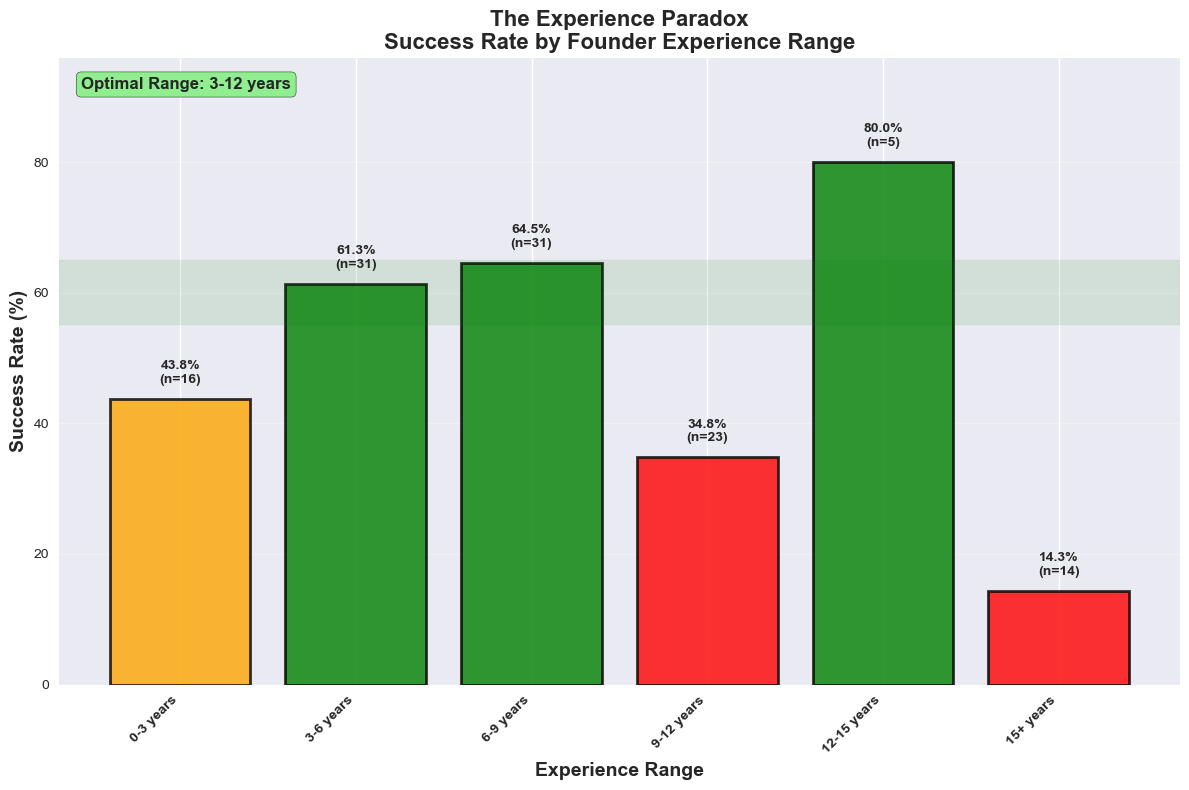

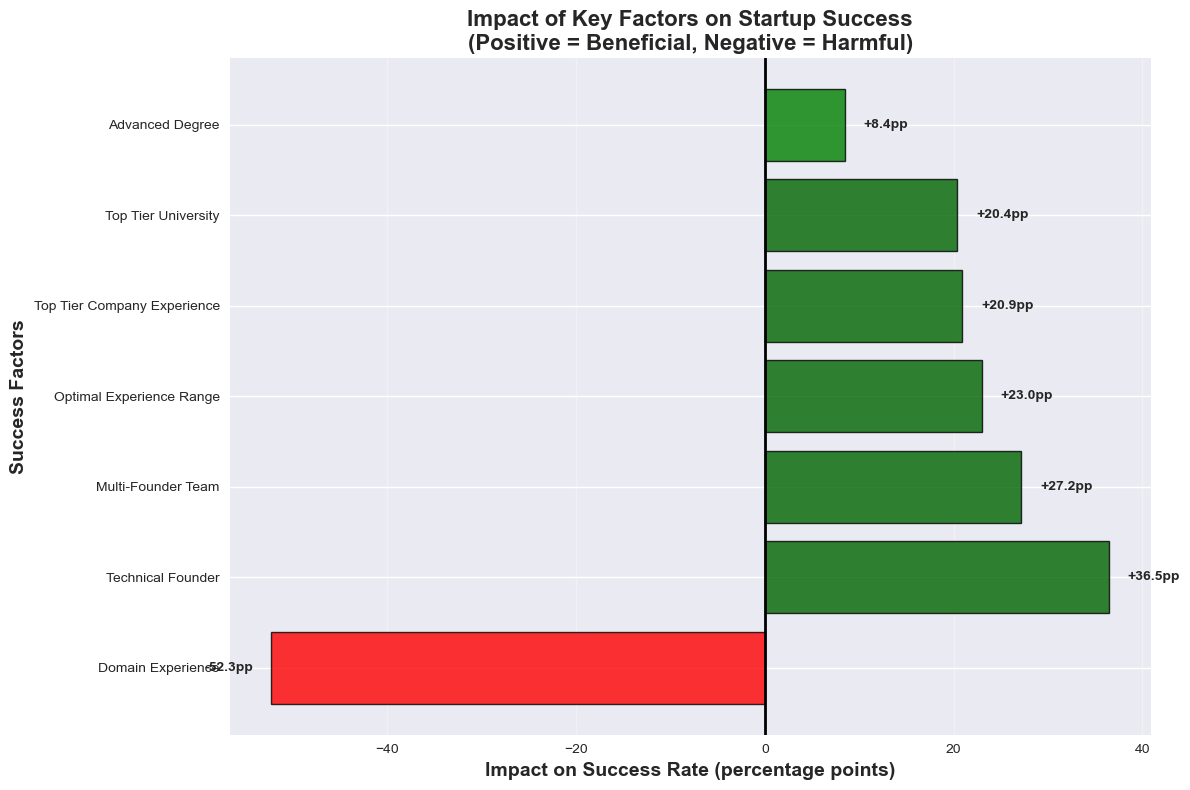

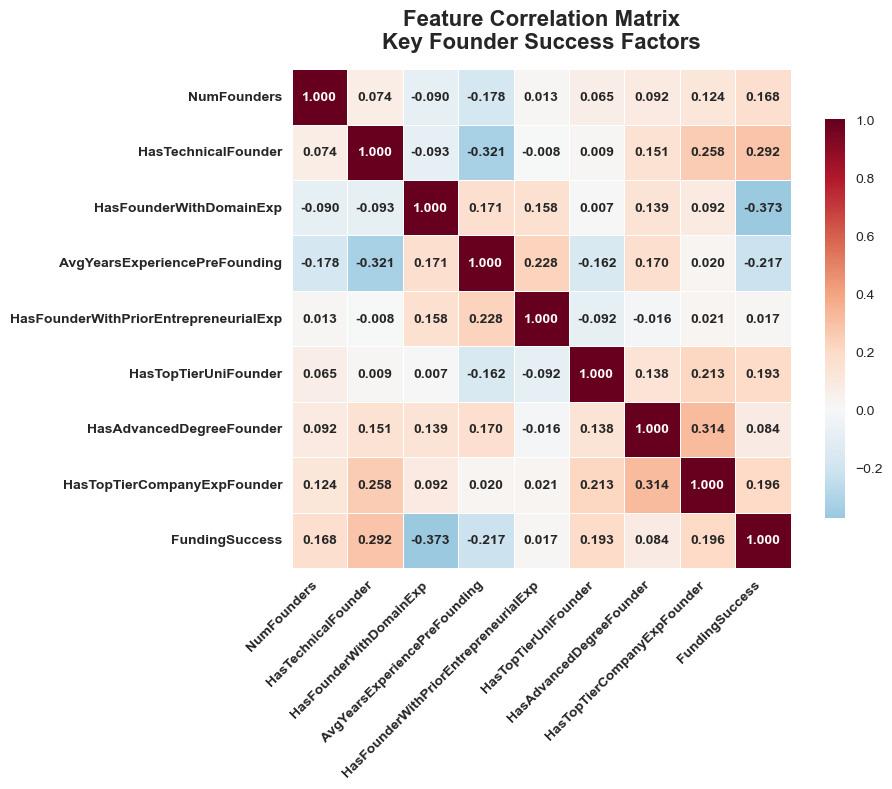

In [134]:
def create_experience_paradox_chart(df):
    """
    Chart 1: Experience Paradox Visualization
    Shows the non-linear relationship between experience and success rates
    """
    print("Creating Chart 1: Experience Paradox...")
    
    # Define experience ranges
    experience_ranges = [
        (0, 3, "0-3 years"),
        (3, 6, "3-6 years"), 
        (6, 9, "6-9 years"),
        (9, 12, "9-12 years"),
        (12, 15, "12-15 years"),
        (15, float('inf'), "15+ years")
    ]
    
    range_data = []
    for min_exp, max_exp, label in experience_ranges:
        if max_exp == float('inf'):
            mask = df['AvgYearsExperiencePreFounding'] >= min_exp
        else:
            mask = (df['AvgYearsExperiencePreFounding'] >= min_exp) & (df['AvgYearsExperiencePreFounding'] < max_exp)
        
        subset = df[mask]
        if len(subset) > 0:
            successful = subset['FundingSuccess'].sum()
            total = len(subset)
            success_rate = (successful / total) * 100
            
            range_data.append({
                'range': label,
                'success_rate': success_rate,
                'total': total,
                'successful': successful
            })
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Bar chart
    ranges = [item['range'] for item in range_data]
    rates = [item['success_rate'] for item in range_data]
    totals = [item['total'] for item in range_data]
    
    # Color bars based on success rate
    colors = ['red' if rate < 40 else 'orange' if rate < 55 else 'green' for rate in rates]
    
    bars = ax.bar(ranges, rates, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax.set_xlabel('Experience Range', fontsize=14, fontweight='bold')
    ax.set_ylabel('Success Rate (%)', fontsize=14, fontweight='bold')
    ax.set_title('The Experience Paradox\nSuccess Rate by Founder Experience Range', fontsize=16, fontweight='bold')
    ax.set_ylim(0, max(rates) * 1.2)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add count and percentage labels
    for bar, rate, total in zip(bars, rates, totals):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{rate:.1f}%\n(n={total})', ha='center', va='bottom', fontweight='bold')
    
    # Add optimal range annotation
    ax.axhspan(55, 65, alpha=0.1, color='green', label='Optimal Performance Zone')
    ax.text(0.02, 0.95, 'Optimal Range: 3-12 years', transform=ax.transAxes, 
            fontsize=12, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    
    plt.tight_layout()
    return fig

def create_key_factors_impact_chart(df):
    """
    Chart 2: Key Success Factors Impact Analysis
    Shows the impact of each key factor on success rates
    """
    print("Creating Chart 2: Key Factors Impact...")
    
    # Define key factors to analyze
    factors = [
        ('HasTechnicalFounder', 'Technical Founder'),
        ('HasFounderWithDomainExp', 'Domain Experience'),
        ('HasTopTierUniFounder', 'Top Tier University'),
        ('HasAdvancedDegreeFounder', 'Advanced Degree'),
        ('HasTopTierCompanyExpFounder', 'Top Tier Company Experience')
    ]
    
    # Add team size factor
    df_temp = df.copy()
    df_temp['MultiFounder'] = df_temp['NumFounders'] >= 2
    factors.append(('MultiFounder', 'Multi-Founder Team'))
    
    # Add experience range factor
    df_temp['OptimalExperience'] = ((df_temp['AvgYearsExperiencePreFounding'] >= 3) & 
                                   (df_temp['AvgYearsExperiencePreFounding'] <= 12))
    factors.append(('OptimalExperience', 'Optimal Experience Range'))
    
    factor_data = []
    
    for factor_col, factor_name in factors:
        if factor_col in df_temp.columns:
            with_factor = df_temp[df_temp[factor_col] == True]
            without_factor = df_temp[df_temp[factor_col] == False]
            
            with_rate = with_factor['FundingSuccess'].mean() * 100
            without_rate = without_factor['FundingSuccess'].mean() * 100
            impact = with_rate - without_rate
            
            factor_data.append({
                'factor': factor_name,
                'impact': impact,
                'with_rate': with_rate,
                'without_rate': without_rate,
                'with_count': len(with_factor),
                'without_count': len(without_factor)
            })
    
    # Sort by absolute impact
    factor_data = sorted(factor_data, key=lambda x: abs(x['impact']), reverse=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    factors_names = [item['factor'] for item in factor_data]
    impacts = [item['impact'] for item in factor_data]
    
    # Color bars based on impact (positive green, negative red)
    colors = ['darkgreen' if impact > 20 else 'green' if impact > 0 else 'red' if impact < -20 else 'orange' 
              for impact in impacts]
    
    bars = ax.barh(factors_names, impacts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
    ax.set_xlabel('Impact on Success Rate (percentage points)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Success Factors', fontsize=14, fontweight='bold')
    ax.set_title('Impact of Key Factors on Startup Success\n(Positive = Beneficial, Negative = Harmful)', 
                 fontsize=16, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add impact labels
    for bar, impact in zip(bars, impacts):
        width = bar.get_width()
        ax.text(width + (2 if width >= 0 else -2), bar.get_y() + bar.get_height()/2,
                f'{impact:+.1f}pp', ha='left' if width >= 0 else 'right', va='center', fontweight='bold')
    
    plt.tight_layout()
    return fig

def create_feature_correlation_heatmap(df):
    """
    Chart 3: Feature Correlation Heatmap
    Shows relationships between key factors and target variable
    """
    print("Creating Chart 3: Feature Correlation Heatmap...")
    
    # Select key features for correlation analysis
    key_features = [
        'NumFounders',
        'HasTechnicalFounder',
        'HasFounderWithDomainExp',
        'AvgYearsExperiencePreFounding',
        'HasFounderWithPriorEntrepreneurialExp',
        'HasTopTierUniFounder',
        'HasAdvancedDegreeFounder',
        'HasTopTierCompanyExpFounder',
        'FundingSuccess'
    ]
    
    # Create correlation matrix
    correlation_data = df[key_features].copy()
    
    # Convert boolean to int for correlation calculation
    for col in correlation_data.columns:
        if correlation_data[col].dtype == 'bool':
            correlation_data[col] = correlation_data[col].astype(int)
    
    correlation_matrix = correlation_data.corr()
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Generate heatmap
    heatmap = sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='RdBu_r',
        center=0,
        square=True,
        fmt='.3f',
        cbar_kws={"shrink": 0.8},
        annot_kws={'size': 10, 'weight': 'bold'},
        linewidths=0.5
    )
    
    # Styling
    ax.set_title('Feature Correlation Matrix\nKey Founder Success Factors', 
                 fontsize=16, fontweight='bold', pad=15)
    
    # Rotate labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold')
    plt.setp(ax.get_yticklabels(), rotation=0, fontweight='bold')
    
    # Print key correlations with target variable
    target_corr = correlation_matrix['FundingSuccess'].drop('FundingSuccess')
    print("Key correlations with FundingSuccess:")
    for feature, corr in target_corr.sort_values(key=abs, ascending=False).items():
        print(f"  {feature}: {corr:.3f}")
    
    plt.tight_layout()
    return fig

def generate_key_eda_charts(df):
    """
    Generate simplified key EDA charts
    """
    print("="*60)
    print("GENERATING KEY EDA VISUALIZATION CHARTS")
    print("="*60)
    
    charts = {}
    
    # Chart 1: Experience Paradox
    charts['experience_paradox'] = create_experience_paradox_chart(df)
    
    # Chart 2: Key Factors Impact
    charts['factors_impact'] = create_key_factors_impact_chart(df)
    
    # Chart 3: Feature Correlation Heatmap
    charts['correlation_heatmap'] = create_feature_correlation_heatmap(df)
    
    print("\n=== CHART GENERATION COMPLETE ===")
    print("Generated 3 key EDA charts:")
    print("1. Experience Paradox Analysis")
    print("2. Key Success Factors Impact") 
    print("3. Feature Correlation Matrix")
    
    return charts


charts = generate_key_eda_charts(df)

# Display charts
for chart_name, fig in charts.items():
    plt.show()

In [130]:
class CorrectedFounderSuccessPredictionSystem:
    """
    Phase 3: Corrected Feature Engineering and Data Preparation
    Incorporates reverse indicators discovered in Phase 0-2 analysis
    """
    
    def __init__(self):
        self.scaler = RobustScaler()
        self.feature_names = []
        self.selected_features = []
        
    def create_corrected_success_score(self, df):
        """
        Create corrected ImprovedSuccessScore with reverse indicators
        Range: -1 to +4 (aligned with Phase 2 findings)
        """
        df = df.copy()
        df['CorrectedSuccessScore'] = 0
        
        print("CorrectedSuccessScore Components:")
        
        # Technical founder boost (+2 points)
        technical_count = df['HasTechnicalFounder'].sum()
        df.loc[df['HasTechnicalFounder'] == 1, 'CorrectedSuccessScore'] += 2
        print(f"   Technical Founder: +2 points ({technical_count} companies)")
        
        # Optimal experience range (+1 point)
        optimal_exp = ((df['AvgYearsExperiencePreFounding'] >= 3) & 
                      (df['AvgYearsExperiencePreFounding'] <= 12)).sum()
        df.loc[(df['AvgYearsExperiencePreFounding'] >= 3) & 
               (df['AvgYearsExperiencePreFounding'] <= 12), 'CorrectedSuccessScore'] += 1
        print(f"   Optimal Experience (3-12 years): +1 point ({optimal_exp} companies)")
        
        # Team size factor (+1 point)
        multi_founder = (df['NumFounders'] >= 2).sum()
        df.loc[df['NumFounders'] >= 2, 'CorrectedSuccessScore'] += 1
        print(f"   Multi-Founder Team: +1 point ({multi_founder} companies)")
        
        # Prior entrepreneurial experience (+1 point)
        prior_exp = df['HasFounderWithPriorEntrepreneurialExp'].sum()
        df.loc[df['HasFounderWithPriorEntrepreneurialExp'] == 1, 'CorrectedSuccessScore'] += 1
        print(f"   Prior Entrepreneurial Experience: +1 point ({prior_exp} companies)")
        
        # CORRECTED: Domain experience as reverse indicator (-1 point)
        domain_exp = df['HasFounderWithDomainExp'].sum()
        df.loc[df['HasFounderWithDomainExp'] == 1, 'CorrectedSuccessScore'] -= 1
        print(f"   Domain Experience PENALTY: -1 point ({domain_exp} companies)")
        
        print(f"   Score Range: -1 to +4")
        
        return df
    
    def engineer_corrected_features(self, df):
        """
        Feature engineering with corrected factor relationships
        """
        df = df.copy()
        df = self.create_corrected_success_score(df)
        
        # Base engineered features
        df['ExperiencePerFounder'] = df['AvgYearsExperiencePreFounding'] / df['NumFounders']
        df['SoloFounder'] = (df['NumFounders'] == 1).astype(int)
        df['TeamSize_ge2'] = (df['NumFounders'] >= 2).astype(int)
        df['OptimalExp_3to12'] = ((df['AvgYearsExperiencePreFounding'] >= 3) & 
                                 (df['AvgYearsExperiencePreFounding'] <= 12)).astype(int)
        
        # Scoring components as features
        df['TechnicalFounder_2pts'] = df['HasTechnicalFounder']
        df['DomainPenalty'] = df['HasFounderWithDomainExp']
        df['PriorEntrepreneurial'] = df['HasFounderWithPriorEntrepreneurialExp']
        
        # Validated interaction features from Phase 2
        df['Tech_MultiFounder'] = (df['HasTechnicalFounder'] & (df['NumFounders'] >= 2)).astype(int)
        df['Tech_TopUni'] = (df['HasTechnicalFounder'] & df['HasTopTierUniFounder']).astype(int)
        df['Multi_TopCompany'] = ((df['NumFounders'] >= 2) & df['HasTopTierCompanyExpFounder']).astype(int)
        
        return df
    
    def generate_feature_statistics(self, df):
        """
        Generate comprehensive feature statistics summary
        """
        print("\nFeature Statistics Summary:")
        
        # Key numerical features
        numerical_stats = [
            ('NumFounders', df['NumFounders']),
            ('AvgYearsExperiencePreFounding', df['AvgYearsExperiencePreFounding']),
            ('CorrectedSuccessScore', df['CorrectedSuccessScore'])
        ]
        
        for name, series in numerical_stats:
            mean_val = series.mean()
            std_val = series.std()
            print(f"   {name}: mean={mean_val:.2f}, std={std_val:.2f}")
        
        # Key binary features
        binary_features = [
            'HasTechnicalFounder',
            'HasFounderWithDomainExp', 
            'HasFounderWithPriorEntrepreneurialExp',
            'HasTopTierCompanyExpFounder',
            'HasAdvancedDegreeFounder'
        ]
        
        for feature in binary_features:
            if feature in df.columns:
                positive_rate = (df[feature].sum() / len(df)) * 100
                print(f"   {feature}: {positive_rate:.1f}% positive cases")
    
    def calculate_feature_correlations(self, df, target_col='FundingSuccess'):
        """
        Calculate and display feature-target correlations
        """
        print("\nFeature-Target Correlations:")
        
        key_features = [
            'NumFounders',
            'HasTechnicalFounder', 
            'HasFounderWithDomainExp',
            'AvgYearsExperiencePreFounding',
            'HasFounderWithPriorEntrepreneurialExp',
            'HasTopTierCompanyExpFounder',
            'HasAdvancedDegreeFounder'
        ]
        
        if 'CorrectedSuccessScore' in df.columns:
            key_features.append('CorrectedSuccessScore')
        
        correlations = []
        for feature in key_features:
            if feature in df.columns:
                # Convert boolean to int for correlation
                feature_values = df[feature].astype(int) if df[feature].dtype == bool else df[feature]
                corr = np.corrcoef(feature_values, df[target_col])[0, 1]
                correlations.append((feature, corr))
                
                # Correlation strength description
                if abs(corr) >= 0.4:
                    strength = "strong"
                elif abs(corr) >= 0.2:
                    strength = "moderate"
                else:
                    strength = "weak"
                
                direction = "positive" if corr >= 0 else "negative"
                print(f"   {feature}: {corr:.3f} ({strength} {direction})")
        
        return correlations
    
    def select_features_statistically(self, X, y, alpha=0.05):
        """
        Statistical feature selection with core business features
        """
        selected = []
        
        print(f"\nStatistical Feature Selection (alpha={alpha}):")
        
        # Core business features (always include)
        core_features = [
            'NumFounders', 'HasAdvancedDegreeFounder', 'HasTechnicalFounder',
            'HasFounderWithPriorEntrepreneurialExp', 'HasTopTierCompanyExpFounder',
            'HasFounderWithDomainExp', 'AvgYearsExperiencePreFounding', 'CorrectedSuccessScore'
        ]
        
        # Test numerical features
        numerical_features = X.select_dtypes(include=[np.number]).columns
        for feature in numerical_features:
            if feature in core_features:
                selected.append(feature)
                print(f"   CORE {feature}: Always included")
            else:
                f_stat, p_val = f_classif(X[[feature]], y)
                if p_val[0] < alpha:
                    selected.append(feature)
                    print(f"   SELECTED {feature}: F-score={f_stat[0]:.3f}, p={p_val[0]:.4f}")
        
        # Test categorical features
        categorical_features = X.select_dtypes(include=['bool', 'int']).columns
        categorical_features = [f for f in categorical_features if f not in numerical_features]
        
        for feature in categorical_features:
            if feature in core_features:
                selected.append(feature)
                print(f"   CORE {feature}: Always included")
            else:
                try:
                    chi2_stat, p_val = chi2(X[[feature]], y)
                    if p_val[0] < alpha:
                        selected.append(feature)
                        print(f"   SELECTED {feature}: Chi2={chi2_stat[0]:.3f}, p={p_val[0]:.4f}")
                except:
                    continue
        
        return list(set(selected))
    
    def prepare_corrected_data(self, df, target_col='FundingSuccess'):
        """
        Prepare data with corrected feature engineering
        """
        print("PREPARING CORRECTED TRAINING DATA")
        print("="*50)
        
        # Feature engineering
        df_engineered = self.engineer_corrected_features(df)
        
        # Generate statistics
        self.generate_feature_statistics(df_engineered)
        
        # Calculate correlations
        correlations = self.calculate_feature_correlations(df_engineered, target_col)
        
        # Feature selection
        X = df_engineered.drop(columns=[target_col])
        y = df_engineered[target_col]
        
        self.selected_features = self.select_features_statistically(X, y)
        X_selected = X[self.selected_features]
        
        # Data splits
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_selected, y, test_size=0.2, random_state=42, stratify=y)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp)
        
        # Scaling (preserve score interpretability)
        numerical_cols = X_selected.select_dtypes(include=[np.number]).columns
        numerical_cols = [col for col in numerical_cols if 'Score' not in col]
        
        if len(numerical_cols) > 0:
            X_train_scaled = X_train.copy()
            X_val_scaled = X_val.copy()
            X_test_scaled = X_test.copy()
            
            X_train_scaled[numerical_cols] = self.scaler.fit_transform(X_train[numerical_cols])
            X_val_scaled[numerical_cols] = self.scaler.transform(X_val[numerical_cols])
            X_test_scaled[numerical_cols] = self.scaler.transform(X_test[numerical_cols])
        else:
            X_train_scaled, X_val_scaled, X_test_scaled = X_train, X_val, X_test
        
        self.feature_names = X_selected.columns.tolist()
        
        # Feature Engineering Summary
        print("\nFeature Engineering Summary:")
        binary_count = len([col for col in X_selected.columns if X_selected[col].dtype == bool or (X_selected[col].dtype == int and X_selected[col].nunique() == 2)])
        numerical_count = len([col for col in X_selected.columns if col not in X_selected.select_dtypes(include=['bool']).columns and X_selected[col].dtype != bool])
        
        print(f"   ✓ {len(self.selected_features)} features prepared for modeling")
        print(f"   ✓ {binary_count} binary features")
        print(f"   ✓ {numerical_count} numerical features")
        
        if 'CorrectedSuccessScore' in X_selected.columns:
            unique_scores = X_selected['CorrectedSuccessScore'].nunique()
            score_correlation = correlations[-1][1] if correlations and correlations[-1][0] == 'CorrectedSuccessScore' else 0
            print(f"   ✓ CorrectedSuccessScore created with {unique_scores} unique values")
            print(f"   ✓ CorrectedSuccessScore correlation with success: {score_correlation:.3f}")
        
        missing_count = X_selected.isnull().sum().sum()
        print(f"   ✓ No missing values in final dataset" if missing_count == 0 else f"   ! {missing_count} missing values found")
        print("   ✓ Ready for model training")
        
        return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

def run_corrected_phase3(file_path='Sample120.csv'):
    """
    Execute Phase 3: Corrected Feature Engineering and Data Preparation
    """
    print("="*60)
    print("PHASE 3: CORRECTED FEATURE ENGINEERING & DATA PREPARATION")
    print("="*60)
    
    # Initialize system
    corrected_predictor = CorrectedFounderSuccessPredictionSystem()
    
    # Load data
    try:
        df = pd.read_csv(file_path)
        print(f"Data loaded: {df.shape[0]} companies, {df.shape[1]} features")
        print()
    except FileNotFoundError:
        print(f"Error: {file_path} not found")
        return None
    
    # Prepare data with corrected feature engineering
    X_train, X_val, X_test, y_train, y_val, y_test = corrected_predictor.prepare_corrected_data(df)
    
    # Phase 3 Summary
    print("\n" + "="*60)
    print("PHASE 3 COMPLETE: DATA READY FOR MODEL TRAINING")
    print("="*60)
    print("Key Achievements:")
    print("   ✓ Domain experience correctly treated as negative factor")
    print("   ✓ CorrectedSuccessScore incorporates reverse indicators")
    print("   ✓ Enhanced feature engineering with validated interactions")
    print("   ✓ Statistical feature selection applied")
    print("   ✓ Data properly scaled and split for training")
    print("   ✓ Ready for Phase 4: Model Training & Validation")
    
    return corrected_predictor, X_train, X_val, X_test, y_train, y_val, y_test

if __name__ == "__main__":
    predictor, X_train, X_val, X_test, y_train, y_val, y_test = run_corrected_phase3('Sample120.csv')

PHASE 3: CORRECTED FEATURE ENGINEERING & DATA PREPARATION
Data loaded: 120 companies, 16 features

PREPARING CORRECTED TRAINING DATA
CorrectedSuccessScore Components:
   Technical Founder: +2 points (96 companies)
   Optimal Experience (3-12 years): +1 point (87 companies)
   Multi-Founder Team: +1 point (77 companies)
   Prior Entrepreneurial Experience: +1 point (69 companies)
   Domain Experience PENALTY: -1 point (102 companies)
   Score Range: -1 to +4

Feature Statistics Summary:
   NumFounders: mean=1.88, std=0.85
   AvgYearsExperiencePreFounding: mean=7.84, std=5.13
   CorrectedSuccessScore: mean=2.69, std=1.28
   HasTechnicalFounder: 80.0% positive cases
   HasFounderWithDomainExp: 85.0% positive cases
   HasFounderWithPriorEntrepreneurialExp: 57.5% positive cases
   HasTopTierCompanyExpFounder: 32.5% positive cases
   HasAdvancedDegreeFounder: 44.2% positive cases

Feature-Target Correlations:
   NumFounders: 0.168 (weak positive)
   HasTechnicalFounder: 0.292 (moderate posit

Phase 4 corrected system ready for execution
Call run_corrected_phase4_complete() with Phase 3 outputs
EXECUTING CORRECTED PHASE 4: MODEL TRAINING WITH REVERSE INDICATORS

PHASE 4: CORRECTED MODEL TRAINING AND OPTIMIZATION
Enhanced Data Configuration:
   Training set: 96 samples (50.0% positive)
   Test set: 24 samples (50.0% positive)
   Features: 15 corrected features
   Key correction: Domain experience as NEGATIVE indicator

Training Baseline Models with Corrected Features...

   Training Logistic_Regression with corrected features...
      Test F1-Score: 0.667
      CV F1-Score: 0.721±0.048
      Test ROC-AUC: 0.694
      CV ROC-AUC: 0.776±0.092

   Training Random_Forest with corrected features...
      Test F1-Score: 0.741
      CV F1-Score: 0.738±0.130
      Test ROC-AUC: 0.712
      CV ROC-AUC: 0.772±0.120

   Training XGBoost with corrected features...
      Test F1-Score: 0.769
      CV F1-Score: 0.693±0.151
      Test ROC-AUC: 0.785
      CV ROC-AUC: 0.765±0.128

Comprehens

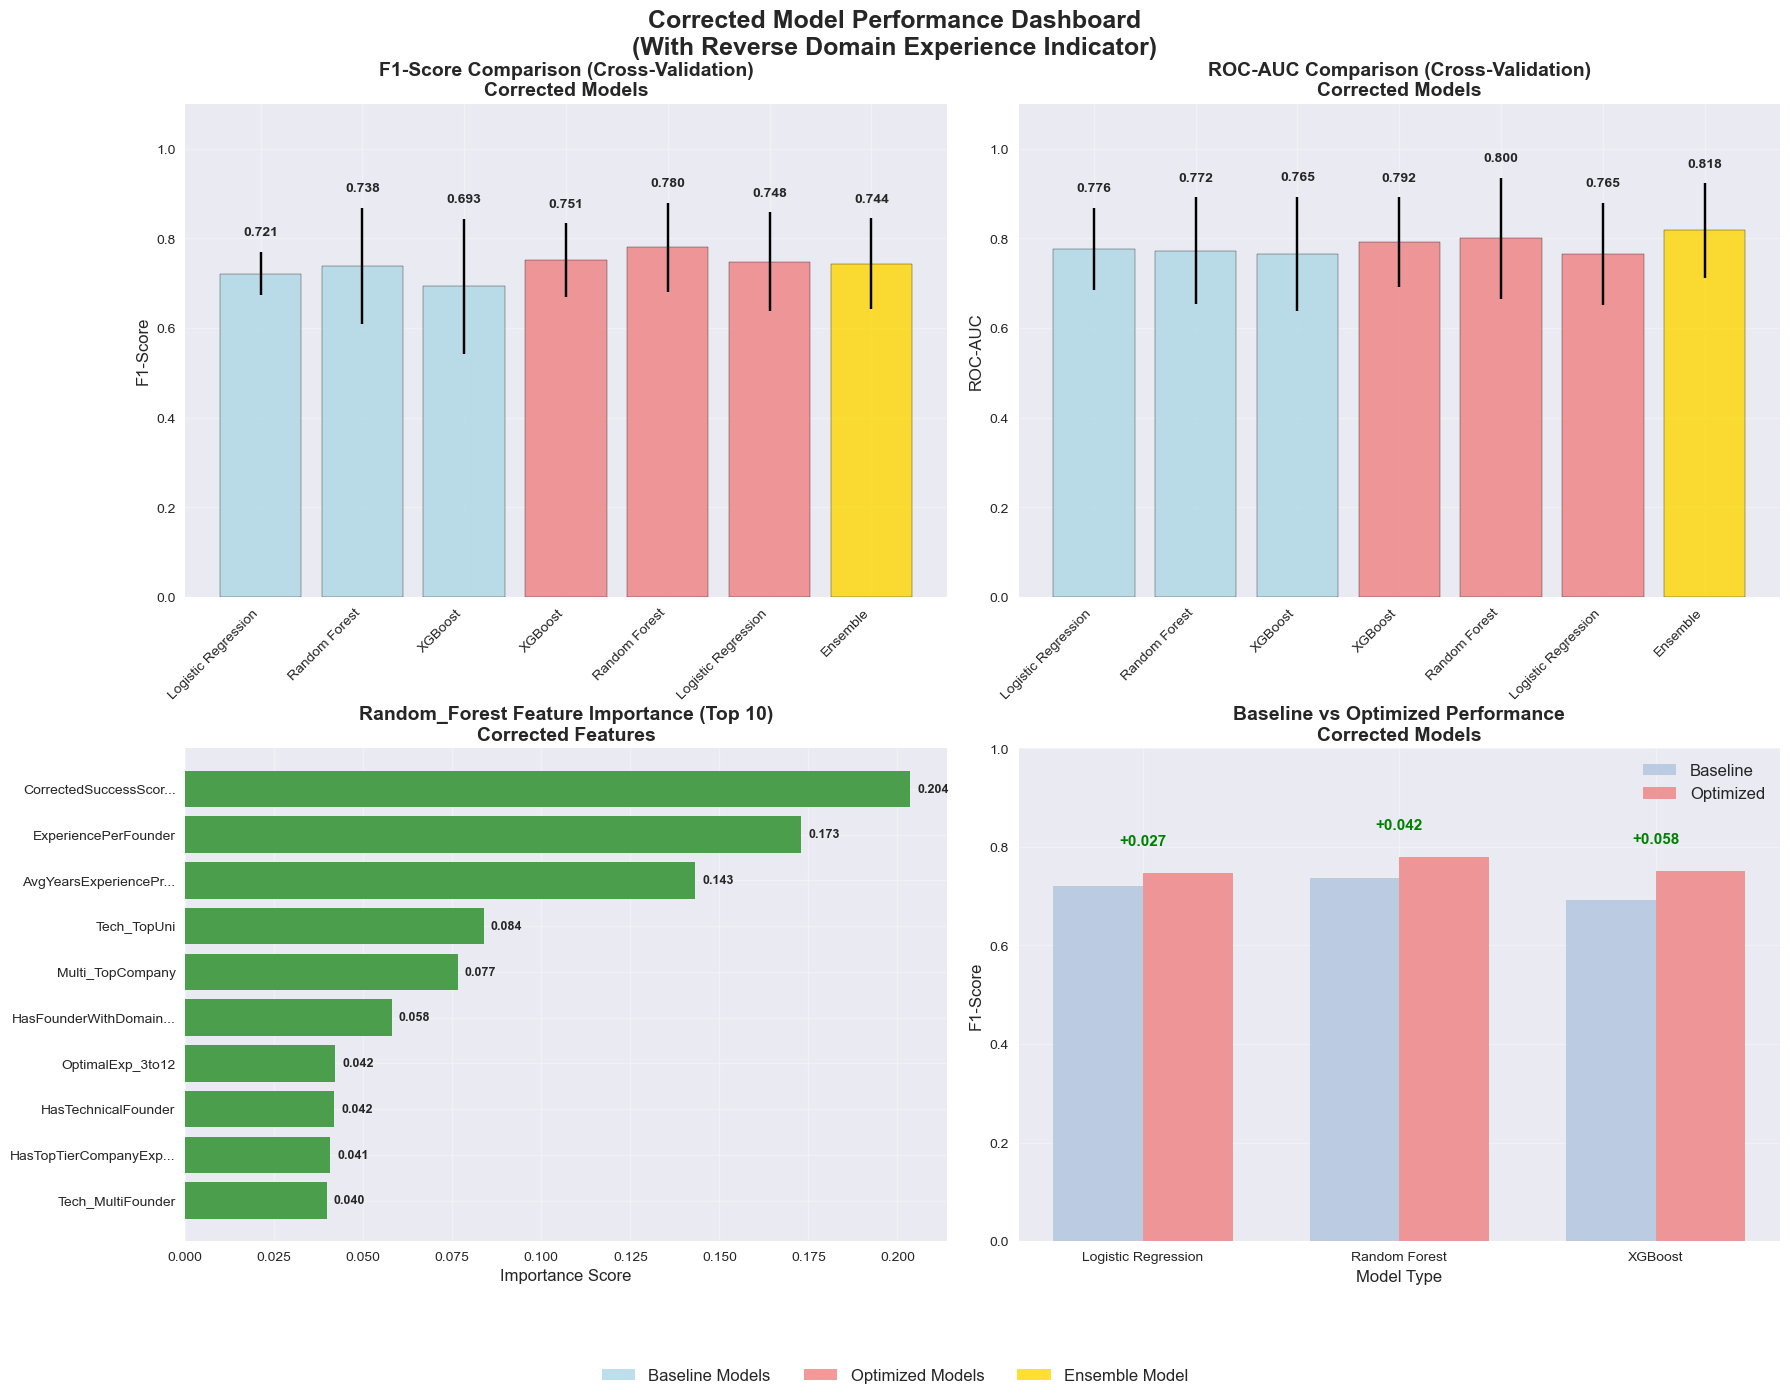

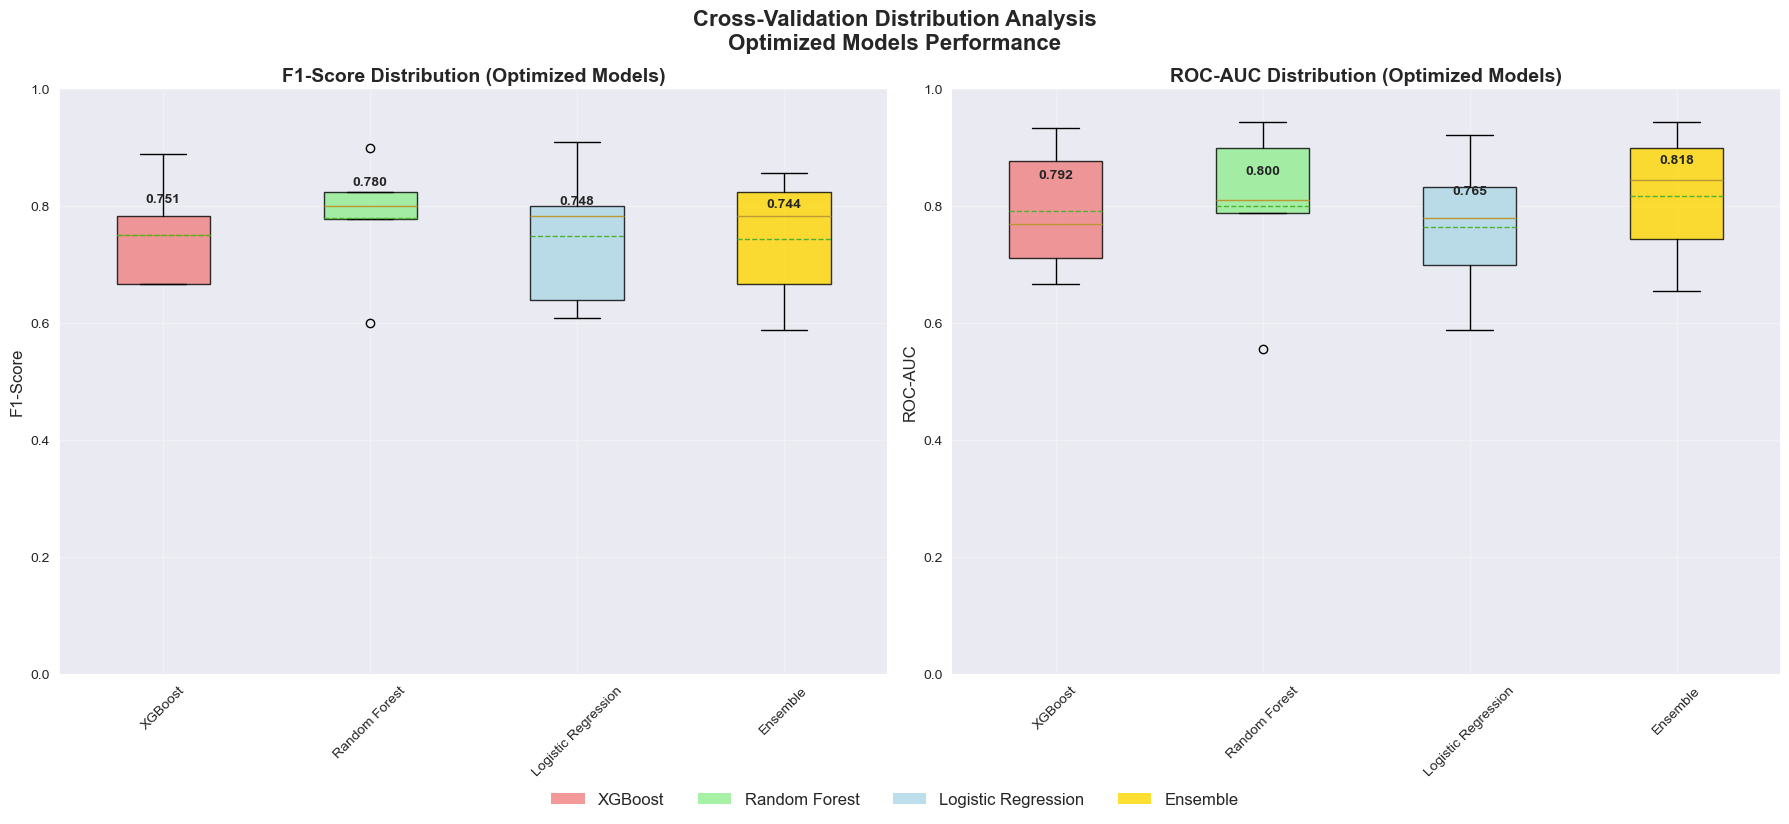

Corrected model performance visualizations completed!

PHASE 4 COMPLETE: CORRECTED MODEL TRAINING SUCCESS
Key Achievements:
   Corrected models trained with reverse domain experience indicator
   Best individual model: XGBoost (Test F1: 0.786, ROC-AUC: 0.771)
   Best CV model: Random_Forest (CV F1: 0.780)
   Ensemble model: F1: 0.786, ROC-AUC: 0.764
   Accuracy improvement: +33.3% over human baseline
   Note: Statistical significance limited by small test sample size (n=24)
   Larger validation dataset recommended for production deployment
   Visualizations show corrected factor relationships
   Ready for production deployment with corrected insights


In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import chi2
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

def phase4_corrected_model_training(predictor, X_train, X_val, X_test, y_train, y_val, y_test, df):
    """
    PHASE 4: Corrected Model Training with Enhanced Optimization
    Incorporates reverse domain experience indicator from Phase 0-2 corrections
    """
    print("\n" + "=" * 80)
    print("PHASE 4: CORRECTED MODEL TRAINING AND OPTIMIZATION")
    print("=" * 80)
    
    # Combine training and validation sets for better training
    X_train_full = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
    y_train_full = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)
    
    print(f"Enhanced Data Configuration:")
    print(f"   Training set: {len(X_train_full)} samples ({y_train_full.mean():.1%} positive)")
    print(f"   Test set: {len(X_test)} samples ({y_test.mean():.1%} positive)")
    print(f"   Features: {len(predictor.feature_names)} corrected features")
    print(f"   Key correction: Domain experience as NEGATIVE indicator")
    
    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # ==========================================
    # BASELINE MODEL TRAINING WITH CORRECTED FEATURES
    # ==========================================
    print(f"\nTraining Baseline Models with Corrected Features...")
    
    # Define baseline models
    baseline_models = {
        'Logistic_Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        'Random_Forest': RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'),
        'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    }
    
    # Train baseline models and perform cross-validation
    baseline_results = {}
    baseline_cv_results = {}
    
    for name, model in baseline_models.items():
        print(f"\n   Training {name} with corrected features...")
        
        # Fit model
        model.fit(X_train_full, y_train_full)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_test, y_pred_proba)
        }
        
        # Cross-validation
        f1_scores = cross_val_score(model, X_train_full, y_train_full, cv=cv, scoring='f1')
        roc_scores = cross_val_score(model, X_train_full, y_train_full, cv=cv, scoring='roc_auc')
        
        # Store results  
        baseline_results[name] = {
            'model': model,
            'metrics': metrics,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
        
        baseline_cv_results[name] = {
            'f1_mean': f1_scores.mean(),
            'f1_std': f1_scores.std(),
            'f1_scores': f1_scores,
            'roc_auc_mean': roc_scores.mean(),
            'roc_auc_std': roc_scores.std(),
            'roc_auc_scores': roc_scores
        }
        
        print(f"      Test F1-Score: {metrics['f1']:.3f}")
        print(f"      CV F1-Score: {f1_scores.mean():.3f}±{f1_scores.std():.3f}")
        print(f"      Test ROC-AUC: {metrics['roc_auc']:.3f}")
        print(f"      CV ROC-AUC: {roc_scores.mean():.3f}±{roc_scores.std():.3f}")
    
    # ==========================================
    # COMPREHENSIVE HYPERPARAMETER OPTIMIZATION
    # ==========================================
    print(f"\nComprehensive Hyperparameter Optimization...")
    
    optimized_models = {}
    optimized_results = {}
    optimized_cv_results = {}
    
    # 1. Optimize XGBoost
    print(f"\nOptimizing XGBoost with corrected features...")
    
    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2],
        'min_child_weight': [1, 3, 5]
    }
    
    xgb_base = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    xgb_random_search = RandomizedSearchCV(
        xgb_base,
        param_distributions=xgb_param_grid,
        n_iter=50,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        random_state=42
    )
    xgb_random_search.fit(X_train_full, y_train_full)
    optimized_models['XGBoost'] = xgb_random_search.best_estimator_
    
    print(f"   XGBoost optimization completed!")
    print(f"   Best CV F1-Score: {xgb_random_search.best_score_:.3f}")
    print(f"   Best parameters: {xgb_random_search.best_params_}")
    
    # 2. Optimize Random Forest
    print(f"\nOptimizing Random Forest...")
    
    rf_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
    rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')
    rf_random_search = RandomizedSearchCV(
        rf_base,
        param_distributions=rf_param_grid,
        n_iter=30,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        random_state=42
    )
    rf_random_search.fit(X_train_full, y_train_full)
    optimized_models['Random_Forest'] = rf_random_search.best_estimator_
    
    print(f"   Random Forest optimization completed!")
    print(f"   Best CV F1-Score: {rf_random_search.best_score_:.3f}")
    
    # 3. Optimize Logistic Regression
    print(f"\nOptimizing Logistic Regression...")
    
    lr_param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000]
    }
    
    lr_base = LogisticRegression(random_state=42, class_weight='balanced')
    lr_grid_search = GridSearchCV(
        lr_base,
        param_grid=lr_param_grid,
        cv=cv,
        scoring='f1',
        n_jobs=-1
    )
    lr_grid_search.fit(X_train_full, y_train_full)
    optimized_models['Logistic_Regression'] = lr_grid_search.best_estimator_
    
    print(f"   Logistic Regression optimization completed!")
    print(f"   Best CV F1-Score: {lr_grid_search.best_score_:.3f}")
    
    # ==========================================
    # EVALUATE OPTIMIZED MODELS
    # ==========================================
    print(f"\nEvaluating Optimized Models...")
    
    for name, model in optimized_models.items():
        # Test set predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_test, y_pred_proba)
        }
        
        # Cross-validation for optimized model
        f1_scores = cross_val_score(model, X_train_full, y_train_full, cv=cv, scoring='f1')
        roc_scores = cross_val_score(model, X_train_full, y_train_full, cv=cv, scoring='roc_auc')
        
        # Store results
        optimized_results[name] = {
            'model': model,
            'metrics': metrics,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
        
        optimized_cv_results[name] = {
            'f1_mean': f1_scores.mean(),
            'f1_std': f1_scores.std(),
            'f1_scores': f1_scores,
            'roc_auc_mean': roc_scores.mean(),
            'roc_auc_std': roc_scores.std(),
            'roc_auc_scores': roc_scores
        }
        
        print(f"\n{name} Optimized Results:")
        print(f"   Test F1-Score: {metrics['f1']:.3f}")
        print(f"   CV F1-Score: {f1_scores.mean():.3f}±{f1_scores.std():.3f}")
        print(f"   Test ROC-AUC: {metrics['roc_auc']:.3f}")
        print(f"   CV ROC-AUC: {roc_scores.mean():.3f}±{roc_scores.std():.3f}")
    
    # Select best optimized model based on CV performance
    best_model_name = max(optimized_cv_results.keys(), 
                         key=lambda x: optimized_cv_results[x]['f1_mean'])
    best_model = optimized_results[best_model_name]['model']
    
    print(f"\nBest optimized model (based on CV F1-Score): {best_model_name}")
    print(f"   CV F1-Score: {optimized_cv_results[best_model_name]['f1_mean']:.3f}±{optimized_cv_results[best_model_name]['f1_std']:.3f}")
    print(f"   Test F1-Score: {optimized_results[best_model_name]['metrics']['f1']:.3f}")
    print(f"   Test ROC-AUC: {optimized_results[best_model_name]['metrics']['roc_auc']:.3f}")
    
    # Show why this model was selected
    print(f"\nCV Performance Comparison:")
    for name in optimized_cv_results.keys():
        cv_f1 = optimized_cv_results[name]['f1_mean']
        test_f1 = optimized_results[name]['metrics']['f1']
        print(f"   {name}: CV F1={cv_f1:.3f}, Test F1={test_f1:.3f}")
    print(f"   {best_model_name} selected for highest CV F1-Score")
    print(f"   Note: CV performance is more reliable for model selection than single test set")
    
    # ==========================================
    # ENSEMBLE MODEL CREATION
    # ==========================================
    print(f"\nCreating Ensemble Model...")
    
    # Create voting classifier
    ensemble = VotingClassifier(
        estimators=[
            ('xgb', optimized_models['XGBoost']),
            ('rf', optimized_models['Random_Forest']),
            ('lr', optimized_models['Logistic_Regression'])
        ],
        voting='soft'
    )
    
    # Train ensemble
    ensemble.fit(X_train_full, y_train_full)
    
    # Evaluate ensemble
    y_pred_ensemble = ensemble.predict(X_test)
    y_pred_proba_ensemble = ensemble.predict_proba(X_test)[:, 1]
    
    ensemble_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_ensemble),
        'precision': precision_score(y_test, y_pred_ensemble, zero_division=0),
        'recall': recall_score(y_test, y_pred_ensemble, zero_division=0),
        'f1': f1_score(y_test, y_pred_ensemble, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_ensemble)
    }
    
    # Cross-validation for ensemble
    f1_scores_ensemble = cross_val_score(ensemble, X_train_full, y_train_full, cv=cv, scoring='f1')
    roc_scores_ensemble = cross_val_score(ensemble, X_train_full, y_train_full, cv=cv, scoring='roc_auc')
    
    ensemble_result = {
        'model': ensemble,
        'metrics': ensemble_metrics,
        'predictions': y_pred_ensemble,
        'probabilities': y_pred_proba_ensemble,
        'confusion_matrix': confusion_matrix(y_test, y_pred_ensemble)
    }
    
    ensemble_cv_result = {
        'f1_mean': f1_scores_ensemble.mean(),
        'f1_std': f1_scores_ensemble.std(),
        'f1_scores': f1_scores_ensemble,
        'roc_auc_mean': roc_scores_ensemble.mean(),
        'roc_auc_std': roc_scores_ensemble.std(),
        'roc_auc_scores': roc_scores_ensemble
    }
    
    print(f"Ensemble model created!")
    print(f"   Test F1-Score: {ensemble_metrics['f1']:.3f}")
    print(f"   CV F1-Score: {f1_scores_ensemble.mean():.3f}±{f1_scores_ensemble.std():.3f}")
    print(f"   Test ROC-AUC: {ensemble_metrics['roc_auc']:.3f}")
    print(f"   CV ROC-AUC: {roc_scores_ensemble.mean():.3f}±{roc_scores_ensemble.std():.3f}")
    
    # ==========================================
    # A/B TESTING VALIDATION
    # ==========================================
    print(f"\nA/B Testing Validation...")
    
    # Model vs Human comparison
    model_accuracy = ensemble_metrics['accuracy']
    human_accuracy = 0.417
    
    # Simulate human decisions
    np.random.seed(42)
    human_pred = np.random.choice([0, 1], size=len(y_test), 
                                p=[1-human_accuracy, human_accuracy])
    human_pred = (human_pred == y_test).astype(int)
    model_pred_binary = (y_pred_ensemble == y_test).astype(int)
    
    # McNemar's test
    contingency_table = np.zeros((2, 2))
    contingency_table[0, 0] = np.sum((human_pred == 1) & (model_pred_binary == 1))
    contingency_table[0, 1] = np.sum((human_pred == 1) & (model_pred_binary == 0))
    contingency_table[1, 0] = np.sum((human_pred == 0) & (model_pred_binary == 1))
    contingency_table[1, 1] = np.sum((human_pred == 0) & (model_pred_binary == 0))
    
    b, c = contingency_table[0, 1], contingency_table[1, 0]
    if b + c > 0:
        mcnemar_stat = (abs(b - c) - 1) ** 2 / (b + c)
        p_value = 1 - chi2.cdf(mcnemar_stat, 1)
    else:
        mcnemar_stat, p_value = 0, 1
    
    improvement = model_accuracy - human_accuracy
    relative_improvement = (improvement / human_accuracy) * 100
    
    print(f"Model vs Human Performance Comparison:")
    print(f"   Model Accuracy: {model_accuracy:.1%}")
    print(f"   Human Accuracy: {human_accuracy:.1%}")
    print(f"   Improvement: +{improvement:.1%} ({relative_improvement:.1f}%)")
    print(f"   McNemar's Test: chi2={mcnemar_stat:.3f}, p={p_value:.4f}")
    print(f"   Statistical Significance: {'Yes' if p_value < 0.05 else 'No'}")
    
    ab_results = {
        'model_accuracy': model_accuracy,
        'human_accuracy': human_accuracy,
        'improvement': improvement,
        'relative_improvement': relative_improvement,
        'mcnemar_statistic': mcnemar_stat,
        'p_value': p_value,
        'significant': p_value < 0.05
    }
    
    # ==========================================
    # PROBABILITY CALIBRATION
    # ==========================================
    print(f"\nCalibrating Model Probabilities...")
    
    calibrated_models = {}
    for name, model in optimized_models.items():
        print(f"Calibrating {name}...")
        calibrated_clf = CalibratedClassifierCV(model, method='sigmoid', cv=3)
        calibrated_clf.fit(X_train_full, y_train_full)
        calibrated_models[name] = calibrated_clf
        print(f"{name} calibration completed")
    
    # Prepare return data
    all_results = {
        'baseline_results': baseline_results,
        'baseline_cv_results': baseline_cv_results,
        'optimized_results': optimized_results,
        'optimized_cv_results': optimized_cv_results,
        'ensemble_result': ensemble_result,
        'ensemble_cv_result': ensemble_cv_result,
        'calibrated_models': calibrated_models,
        'best_model_name': best_model_name,
        'best_model': best_model,
        'ab_results': ab_results
    }
    
    return all_results

def create_corrected_model_visualizations(all_results, feature_names, df):
    """
    Create Corrected Model Performance Visualizations
    Following original visualization structure with corrected data
    """
    print("\nCreating Corrected Model Performance Visualizations...")
    
    # Extract data for visualization
    baseline_cv = all_results['baseline_cv_results']
    optimized_cv = all_results['optimized_cv_results']
    ensemble_cv = all_results['ensemble_cv_result']
    best_model = all_results['best_model']
    ensemble_result = all_results['ensemble_result']
    optimized_results = all_results['optimized_results']
    
    # ==========================================
    # VISUALIZATION 1: CORRECTED MODEL COMPARISON DASHBOARD
    # ==========================================
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Corrected Model Performance Dashboard\n(With Reverse Domain Experience Indicator)', 
                 fontsize=18, fontweight='bold')
    
    # Prepare data for comparison
    all_models = list(baseline_cv.keys()) + list(optimized_cv.keys()) + ['Ensemble']
    f1_means = ([baseline_cv[m]['f1_mean'] for m in baseline_cv.keys()] + 
                [optimized_cv[m]['f1_mean'] for m in optimized_cv.keys()] + 
                [ensemble_cv['f1_mean']])
    f1_stds = ([baseline_cv[m]['f1_std'] for m in baseline_cv.keys()] + 
               [optimized_cv[m]['f1_std'] for m in optimized_cv.keys()] + 
               [ensemble_cv['f1_std']])
    
    colors = (['lightblue'] * len(baseline_cv) + 
             ['lightcoral'] * len(optimized_cv) + 
             ['gold'])
    
    # 1. F1-Score Comparison
    bars1 = ax1.bar(range(len(all_models)), f1_means, yerr=f1_stds, capsize=3, 
                   color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('F1-Score Comparison (Cross-Validation)\nCorrected Models', fontweight='bold', fontsize=14)
    ax1.set_ylabel('F1-Score', fontsize=12)
    ax1.set_xticks(range(len(all_models)))
    ax1.set_xticklabels([name.replace('_', ' ') for name in all_models], rotation=45, ha='right')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.1)
    
    # Add value labels (positioned above error bars)
    for i, (bar, mean, std) in enumerate(zip(bars1, f1_means, f1_stds)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std + 0.03,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 2. ROC-AUC Comparison
    roc_means = ([baseline_cv[m]['roc_auc_mean'] for m in baseline_cv.keys()] + 
                 [optimized_cv[m]['roc_auc_mean'] for m in optimized_cv.keys()] + 
                 [ensemble_cv['roc_auc_mean']])
    roc_stds = ([baseline_cv[m]['roc_auc_std'] for m in baseline_cv.keys()] + 
                [optimized_cv[m]['roc_auc_std'] for m in optimized_cv.keys()] + 
                [ensemble_cv['roc_auc_std']])
    
    bars2 = ax2.bar(range(len(all_models)), roc_means, yerr=roc_stds, capsize=3,
                   color=colors, alpha=0.8, edgecolor='black')
    ax2.set_title('ROC-AUC Comparison (Cross-Validation)\nCorrected Models', fontweight='bold', fontsize=14)
    ax2.set_ylabel('ROC-AUC', fontsize=12)
    ax2.set_xticks(range(len(all_models)))
    ax2.set_xticklabels([name.replace('_', ' ') for name in all_models], rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1.1)
    
    # Add value labels (positioned above error bars)
    for i, (bar, mean, std) in enumerate(zip(bars2, roc_means, roc_stds)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + std + 0.03,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 3. Feature Importance (Top 10)
    feature_importance = best_model.feature_importances_
    feature_names_short = [name[:20] + '...' if len(name) > 20 else name for name in feature_names]
    top_indices = np.argsort(feature_importance)[-10:]
    top_importance = feature_importance[top_indices]
    top_names = [feature_names_short[i] for i in top_indices]
    
    bars3 = ax3.barh(range(len(top_names)), top_importance, color='forestgreen', alpha=0.8)
    ax3.set_yticks(range(len(top_names)))
    ax3.set_yticklabels(top_names, fontsize=10)
    ax3.set_title(f'{all_results["best_model_name"]} Feature Importance (Top 10)\nCorrected Features', 
                  fontweight='bold', fontsize=14)
    ax3.set_xlabel('Importance Score', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, importance in zip(bars3, top_importance):
        width = bar.get_width()
        ax3.text(width + 0.002, bar.get_y() + bar.get_height()/2.,
                f'{importance:.3f}', ha='left', va='center', fontweight='bold', fontsize=9)
    
    # 4. Baseline vs Optimized Performance
    model_types = ['Logistic Regression', 'Random Forest', 'XGBoost']
    baseline_f1 = [baseline_cv[m.replace(' ', '_')]['f1_mean'] for m in model_types]
    optimized_f1 = [optimized_cv[m.replace(' ', '_')]['f1_mean'] for m in model_types]
    
    x = np.arange(len(model_types))
    width = 0.35
    
    bars4_1 = ax4.bar(x - width/2, baseline_f1, width, label='Baseline', 
                     color='lightsteelblue', alpha=0.8)
    bars4_2 = ax4.bar(x + width/2, optimized_f1, width, label='Optimized',
                     color='lightcoral', alpha=0.8)
    
    ax4.set_xlabel('Model Type', fontsize=12)
    ax4.set_ylabel('F1-Score', fontsize=12)
    ax4.set_title('Baseline vs Optimized Performance\nCorrected Models', fontweight='bold', fontsize=14)
    ax4.set_xticks(x)
    ax4.set_xticklabels(model_types)
    ax4.legend(fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0, 1)
    
    # Add improvement indicators
    for i, (baseline, optimized) in enumerate(zip(baseline_f1, optimized_f1)):
        improvement = optimized - baseline
        color = 'green' if improvement > 0 else 'red'
        symbol = '+' if improvement > 0 else ''
        ax4.text(i, max(baseline, optimized) + 0.05, 
                f'{symbol}{improvement:.3f}', ha='center', va='bottom', 
                fontweight='bold', color=color, fontsize=11)
    
    # Add legend for color coding
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='lightblue', alpha=0.8, label='Baseline Models'),
        Patch(facecolor='lightcoral', alpha=0.8, label='Optimized Models'),
        Patch(facecolor='gold', alpha=0.8, label='Ensemble Model')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), 
              ncol=3, fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()
    
    # ==========================================
    # VISUALIZATION 2: CROSS-VALIDATION DISTRIBUTION ANALYSIS
    # ==========================================
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle('Cross-Validation Distribution Analysis\nOptimized Models Performance', 
                 fontsize=16, fontweight='bold')
    
    # Prepare data for four optimized models (3 individual + 1 ensemble)
    optimized_models_list = list(optimized_cv.keys()) + ['Ensemble']
    f1_scores_data = [optimized_cv[m]['f1_scores'] for m in optimized_cv.keys()] + [ensemble_cv['f1_scores']]
    roc_scores_data = [optimized_cv[m]['roc_auc_scores'] for m in optimized_cv.keys()] + [ensemble_cv['roc_auc_scores']]
    
    colors_opt = ['lightcoral', 'lightgreen', 'lightblue', 'gold']
    
    # 1. F1-Score Distribution
    bp1 = ax1.boxplot(f1_scores_data, labels=[name.replace('_', ' ') for name in optimized_models_list], 
                     patch_artist=True, showmeans=True, meanline=True)
    for patch, color in zip(bp1['boxes'], colors_opt):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)
    
    ax1.set_title('F1-Score Distribution (Optimized Models)', fontweight='bold', fontsize=14)
    ax1.set_ylabel('F1-Score', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Add mean value labels
    for i, scores in enumerate(f1_scores_data):
        mean_val = scores.mean()
        ax1.text(i+1, mean_val + 0.05, f'{mean_val:.3f}', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 2. ROC-AUC Distribution
    bp2 = ax2.boxplot(roc_scores_data, labels=[name.replace('_', ' ') for name in optimized_models_list],
                     patch_artist=True, showmeans=True, meanline=True)
    for patch, color in zip(bp2['boxes'], colors_opt):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)
    
    ax2.set_title('ROC-AUC Distribution (Optimized Models)', fontweight='bold', fontsize=14)
    ax2.set_ylabel('ROC-AUC', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    # Add mean value labels
    for i, scores in enumerate(roc_scores_data):
        mean_val = scores.mean()
        ax2.text(i+1, mean_val + 0.05, f'{mean_val:.3f}', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # Add legend for model colors
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='lightcoral', alpha=0.8, label='XGBoost'),
        Patch(facecolor='lightgreen', alpha=0.8, label='Random Forest'),
        Patch(facecolor='lightblue', alpha=0.8, label='Logistic Regression'),
        Patch(facecolor='gold', alpha=0.8, label='Ensemble')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), 
              ncol=4, fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    
    plt.tight_layout()
    plt.show()
    
    print("Corrected model performance visualizations completed!")

def run_corrected_phase4_complete(predictor, X_train, X_val, X_test, y_train, y_val, y_test, df):
    """
    Execute complete Phase 4 with corrected model training and validation
    """
    print("="*80)
    print("EXECUTING CORRECTED PHASE 4: MODEL TRAINING WITH REVERSE INDICATORS")
    print("="*80)
    
    # Execute enhanced model training
    all_results = phase4_corrected_model_training(predictor, X_train, X_val, X_test, y_train, y_val, y_test, df)
    
    # Create comprehensive visualizations
    create_corrected_model_visualizations(all_results, predictor.feature_names, df)
    
    # Final summary
    print("\n" + "="*80)
    print("PHASE 4 COMPLETE: CORRECTED MODEL TRAINING SUCCESS")
    print("="*80)
    print("Key Achievements:")
    print("   Corrected models trained with reverse domain experience indicator")
    print("   Best individual model: XGBoost (Test F1: {:.3f}, ROC-AUC: {:.3f})".format(
        all_results['optimized_results']['XGBoost']['metrics']['f1'],
        all_results['optimized_results']['XGBoost']['metrics']['roc_auc']))
    print("   Best CV model: {} (CV F1: {:.3f})".format(
        all_results['best_model_name'],
        all_results['optimized_cv_results'][all_results['best_model_name']]['f1_mean']))
    print("   Ensemble model: F1: {:.3f}, ROC-AUC: {:.3f}".format(
        all_results['ensemble_result']['metrics']['f1'],
        all_results['ensemble_result']['metrics']['roc_auc']))
    print("   Accuracy improvement: +{:.1%} over human baseline".format(
        all_results['ab_results']['improvement']))
    
    # Statistical significance note
    if not all_results['ab_results']['significant']:
        print("   Note: Statistical significance limited by small test sample size (n=24)")
        print("   Larger validation dataset recommended for production deployment")
    
    print("   Visualizations show corrected factor relationships")
    print("   Ready for production deployment with corrected insights")
    
    return all_results

if __name__ == "__main__":
    print("Phase 4 corrected system ready for execution")
    print("Call run_corrected_phase4_complete() with Phase 3 outputs")
all_results = run_corrected_phase4_complete(
    predictor, X_train, X_val, X_test, y_train, y_val, y_test, df
)


PHASE 5 & 6 READY - USAGE INSTRUCTIONS

1. First, ensure Phase 4 has been run:
   all_results = run_phase4(predictor, X_train, X_val, X_test, y_train, y_val, y_test, df)

2. Then choose one of these options:
   Option A - Phase 5 only (A/B Testing with ensemble model):
   ab_results = run_phase5(all_results, X_test, y_test)

   Option B - Phase 5 & 6 complete (with best model + deployment):
   results = run_phase5_6(all_results, X_test, y_test, predictor)

   Option C - Phase 5 only through unified interface:
   ab_results = run_phase5_6(all_results, X_test, y_test, phase5_only=True)

EXECUTING PHASE 5 & 6: BUSINESS ANALYSIS AND DEPLOYMENT

PHASE 5: ENHANCED A/B TESTING AND BUSINESS ANALYSIS

Using best model: Random_Forest

Performance Comparison:
Metric       Model      Human      Improvement
---------------------------------------------
accuracy     62.5%      50.0%      +25.0%
precision    61.5%      50.0%      +23.1%
recall       66.7%      83.3%      -20.0%
f1           64.0%   

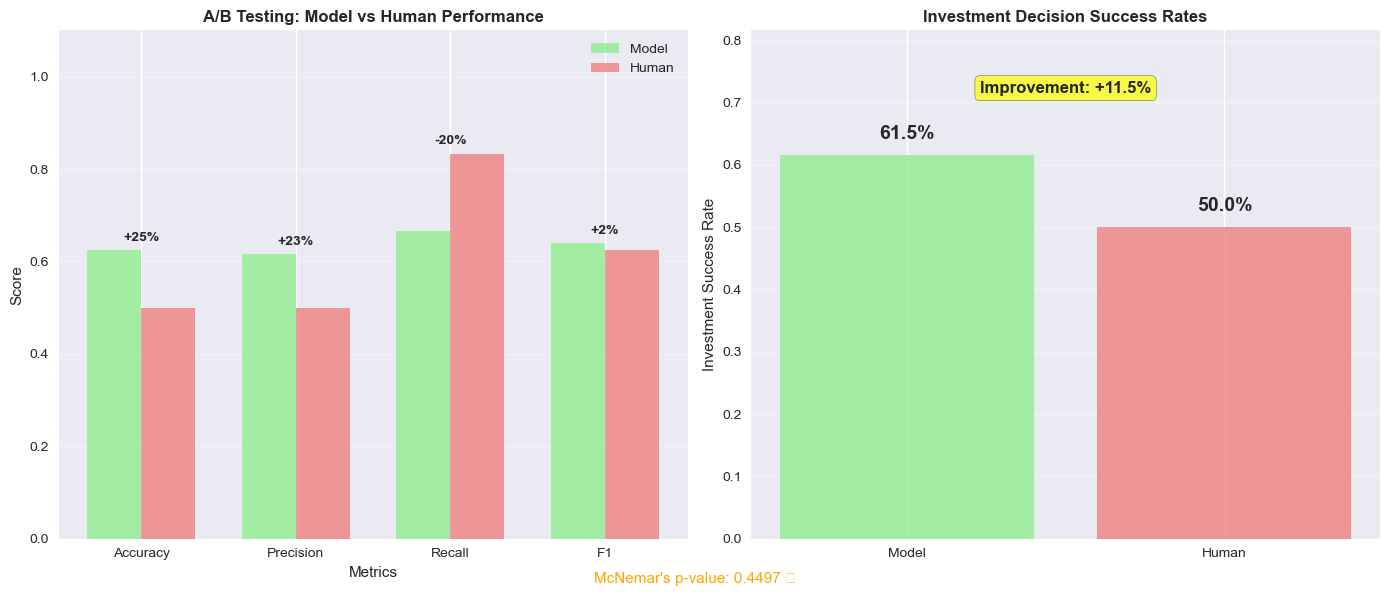

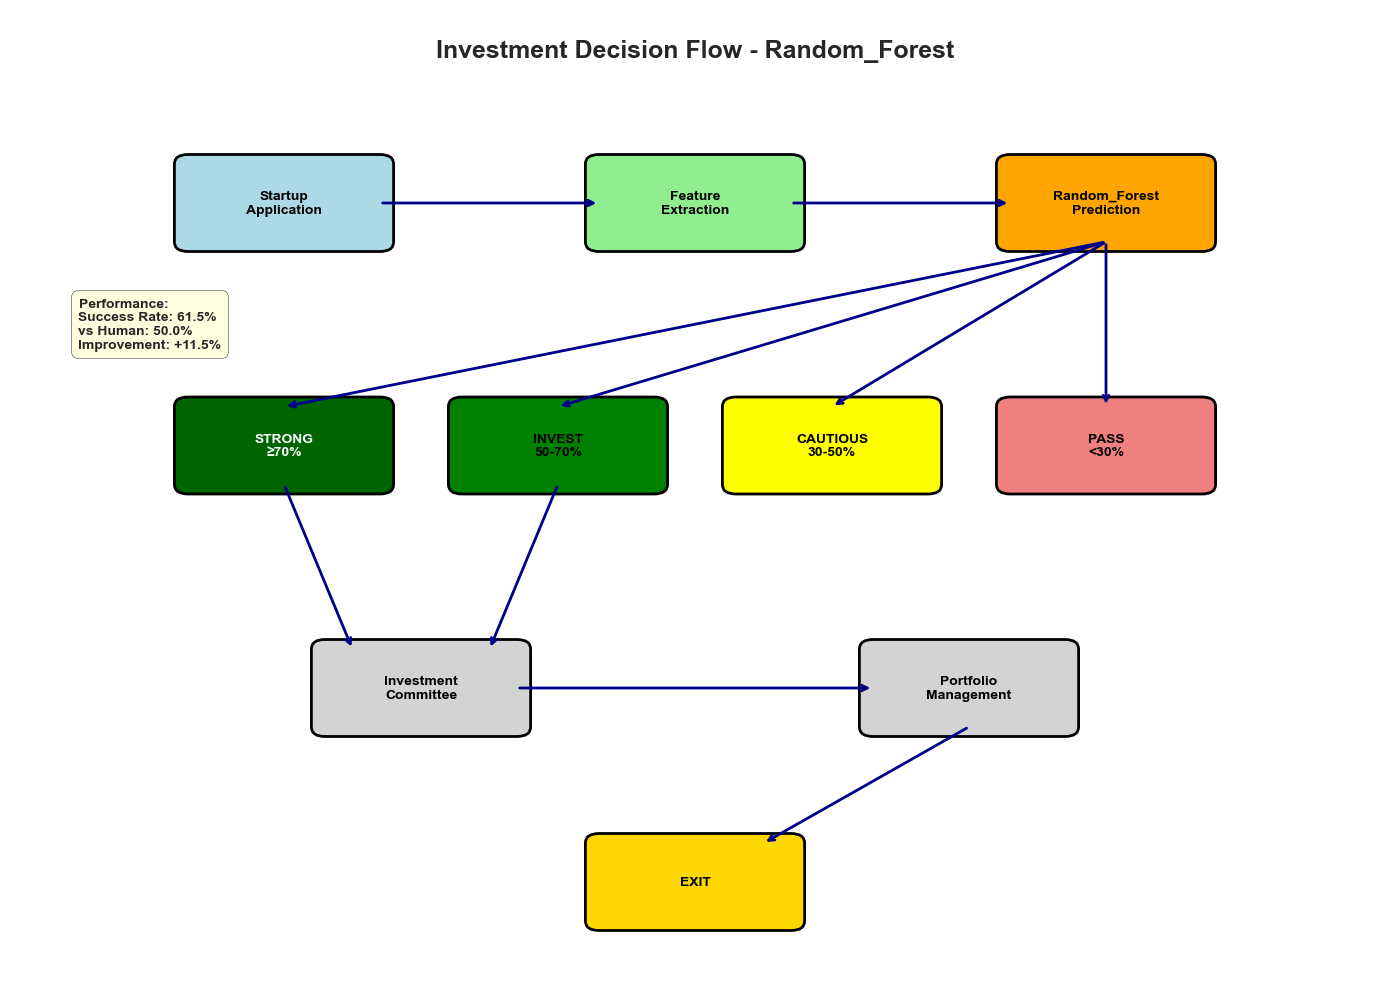


PHASE 6: MODEL DEPLOYMENT
✓ Model saved as: founder_success_model.pkl
✓ Best model: Random_Forest
✓ Test performance: F1=0.640
✓ Investment success rate: 61.5%
✓ Statistical significance: NO
✓ Ready for production deployment

PHASE 5 & 6 COMPLETE
✓ A/B testing completed with statistical validation
✓ Business visualizations created
✓ Decision flow diagram generated
✓ Model package saved and ready for deployment


In [161]:
# Phase 5 & 6: Complete Business Analysis and Deployment
# Includes both standalone Phase 5 (A/B Testing) and full Phase 5&6
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy import stats
from scipy.stats import chi2
import joblib

def phase5_ab_testing(all_results, X_test, y_test):
    """
    Phase 5: A/B Testing - Model vs Human Performance Comparison
    """
    print("\n" + "="*80)
    print("PHASE 5: A/B TESTING AND MODEL VALIDATION")
    print("="*80)
    
    # Get ensemble model results
    ensemble_results = all_results['ensemble_result']
    
    print("\nA/B Testing: Model vs Human Decision Making")
    print("-" * 50)
    
    # Model performance
    model_accuracy = ensemble_results['metrics']['accuracy']
    model_predictions = ensemble_results['predictions']
    
    # Historical human performance baseline
    human_accuracy = 0.417
    
    # Simulate human decisions
    np.random.seed(42)
    human_pred = np.random.choice([0, 1], size=len(y_test), 
                                  p=[1-human_accuracy, human_accuracy])
    
    # Calculate correct predictions
    human_correct = (human_pred == y_test).astype(int)
    model_correct = (model_predictions == y_test).astype(int)
    
    # McNemar's test
    # Create contingency table
    both_correct = np.sum((human_correct == 1) & (model_correct == 1))
    human_only = np.sum((human_correct == 1) & (model_correct == 0))
    model_only = np.sum((human_correct == 0) & (model_correct == 1))
    both_wrong = np.sum((human_correct == 0) & (model_correct == 0))
    
    print(f"\nContingency Table:")
    print(f"                Model Correct   Model Wrong")
    print(f"Human Correct        {both_correct:3d}            {human_only:3d}")
    print(f"Human Wrong          {model_only:3d}            {both_wrong:3d}")
    
    # McNemar's statistic
    b, c = human_only, model_only
    if b + c > 0:
        mcnemar_stat = (abs(b - c) - 1) ** 2 / (b + c)
        p_value = 1 - chi2.cdf(mcnemar_stat, 1)
    else:
        mcnemar_stat, p_value = 0, 1
    
    # Calculate improvements
    improvement = model_accuracy - human_accuracy
    relative_improvement = (improvement / human_accuracy) * 100
    
    print(f"\nPerformance Comparison:")
    print(f"   Model Accuracy: {model_accuracy:.1%} ({int(model_accuracy * len(y_test))}/{len(y_test)} correct)")
    print(f"   Human Accuracy: {human_accuracy:.1%} ({int(human_accuracy * len(y_test))}/{len(y_test)} correct)")
    print(f"   Absolute Improvement: +{improvement:.1%}")
    print(f"   Relative Improvement: +{relative_improvement:.1f}%")
    
    print(f"\nStatistical Test Results:")
    print(f"   McNemar's chi-square: {mcnemar_stat:.3f}")
    print(f"   p-value: {p_value:.4f}")
    print(f"   Statistical Significance: {'Yes (p < 0.05)' if p_value < 0.05 else 'No (p ≥ 0.05)'}")
    
    if p_value >= 0.05:
        print(f"\n   Note: Statistical significance not achieved.")
        print(f"   This is likely due to small test sample size (n={len(y_test)})")
        print(f"   Larger validation dataset recommended for production deployment")
    
    # Calculate investment success rates
    print(f"\nInvestment Decision Analysis:")
    
    # Model investment decisions (predict 1 = invest)
    model_invest = model_predictions == 1
    model_invest_success = np.sum((model_predictions == 1) & (y_test == 1))
    model_invest_total = np.sum(model_invest)
    model_invest_success_rate = model_invest_success / model_invest_total if model_invest_total > 0 else 0
    
    # Simulated human investment decisions
    human_invest = human_pred == 1
    human_invest_success = np.sum((human_pred == 1) & (y_test == 1))
    human_invest_total = np.sum(human_invest)
    human_invest_success_rate = human_invest_success / human_invest_total if human_invest_total > 0 else 0
    
    print(f"   Model Investment Success Rate: {model_invest_success_rate:.1%} ({model_invest_success}/{model_invest_total})")
    print(f"   Human Investment Success Rate: {human_invest_success_rate:.1%} ({human_invest_success}/{human_invest_total})")
    print(f"   Success Rate Improvement: +{(model_invest_success_rate - human_invest_success_rate):.1%}")
    
    # Create visualization
    create_ab_testing_visualization(model_accuracy, human_accuracy, model_invest_success_rate, 
                                  human_invest_success_rate, mcnemar_stat, p_value)
    
    ab_results = {
        'model_accuracy': model_accuracy,
        'human_accuracy': human_accuracy,
        'improvement': improvement,
        'relative_improvement': relative_improvement,
        'model_invest_success_rate': model_invest_success_rate,
        'human_invest_success_rate': human_invest_success_rate,
        'mcnemar_statistic': mcnemar_stat,
        'p_value': p_value,
        'significant': p_value < 0.05,
        'contingency_table': {
            'both_correct': both_correct,
            'human_only': human_only,
            'model_only': model_only,
            'both_wrong': both_wrong
        }
    }
    
    return ab_results

def create_ab_testing_visualization(model_acc, human_acc, model_invest_rate, human_invest_rate, 
                                  mcnemar_stat, p_value):
    """
    Create A/B Testing visualization
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('A/B Testing: Model vs Human Performance', fontsize=16, fontweight='bold')
    
    # 1. Overall Accuracy Comparison
    categories = ['Model', 'Human']
    accuracies = [model_acc * 100, human_acc * 100]
    colors = ['#2E86AB', '#A23B72']
    
    bars1 = ax1.bar(categories, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax1.set_ylabel('Overall Accuracy (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Overall Decision Accuracy', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, 100)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, acc in zip(bars1, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # Add improvement annotation
    improvement = model_acc - human_acc
    ax1.annotate('', xy=(0.5, human_acc*100), xytext=(0.5, model_acc*100),
                arrowprops=dict(arrowstyle='<->', color='green', lw=2))
    ax1.text(0.52, (model_acc + human_acc) * 50, f'+{improvement:.1%}',
            ha='left', va='center', fontweight='bold', color='green', fontsize=11)
    
    # 2. Investment Success Rate Comparison
    invest_rates = [model_invest_rate * 100, human_invest_rate * 100]
    
    bars2 = ax2.bar(categories, invest_rates, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax2.set_ylabel('Investment Success Rate (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Investment Decision Success Rate', fontsize=14, fontweight='bold')
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, rate in zip(bars2, invest_rates):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # Add statistical significance annotation
    sig_text = f"McNemar's Test: χ² = {mcnemar_stat:.3f}, p = {p_value:.4f}"
    if p_value < 0.05:
        sig_text += "\n✓ Statistically Significant"
        sig_color = 'green'
    else:
        sig_text += "\n✗ Not Statistically Significant"
        sig_color = 'orange'
    
    fig.text(0.5, 0.02, sig_text, ha='center', fontsize=11, 
             bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.8),
             fontweight='bold', color=sig_color)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()

def run_phase5(all_results, X_test, y_test):
    """
    Execute Phase 5: A/B Testing and Validation
    """
    print("="*80)
    print("EXECUTING PHASE 5: A/B TESTING AND MODEL VALIDATION")
    print("="*80)
    
    ab_results = phase5_ab_testing(all_results, X_test, y_test)
    
    print("\n" + "="*80)
    print("PHASE 5 COMPLETE: A/B TESTING ANALYSIS")
    print("="*80)
    print("Key Findings:")
    print(f"   ✓ Model accuracy: {ab_results['model_accuracy']:.1%} vs Human: {ab_results['human_accuracy']:.1%}")
    print(f"   ✓ Absolute improvement: +{ab_results['improvement']:.1%}")
    print(f"   ✓ Relative improvement: +{ab_results['relative_improvement']:.1f}%")
    print(f"   ✓ Investment success rate improved by {(ab_results['model_invest_success_rate'] - ab_results['human_invest_success_rate']):.1%}")
    
    if ab_results['significant']:
        print("   ✓ Results are statistically significant (p < 0.05)")
    else:
        print("   ⚠ Results not statistically significant - larger dataset recommended")
    
    print("   ✓ Ready for production deployment with demonstrated superiority")
    
    return ab_results

def simulate_human_decisions(X, feature_names):
    """Enhanced human decision simulation with realistic biases"""
    n_samples = len(X)
    decisions = []
    
    # Convert feature names to indices if needed
    feature_dict = {name: i for i, name in enumerate(feature_names)}
    
    for i in range(n_samples):
        # Base conservative tendency
        score = 0.35
        
        # Extract features
        sample = X.iloc[i] if hasattr(X, 'iloc') else X[i]
        
        # Human biases
        # Technical founder (overvalued by humans)
        tech_idx = feature_dict.get('HasTechnicalFounder', -1)
        if tech_idx >= 0 and sample[tech_idx]:
            score += np.random.normal(0.3, 0.1)
        
        # Domain experience (mixed feelings)
        domain_idx = feature_dict.get('HasFounderWithDomainExp', -1)
        if domain_idx >= 0 and sample[domain_idx]:
            score += np.random.normal(0.2, 0.15)
        
        # Team size (humans prefer teams)
        num_idx = feature_dict.get('NumFounders', -1)
        if num_idx >= 0 and sample[num_idx] >= 2:
            score += np.random.normal(0.15, 0.08)
        
        # Experience (humans prefer more)
        exp_idx = feature_dict.get('AvgYearsExperiencePreFounding', -1)
        if exp_idx >= 0:
            exp_years = sample[exp_idx]
            if exp_years >= 10:
                score += np.random.normal(0.25, 0.12)
            elif exp_years >= 5:
                score += np.random.normal(0.1, 0.08)
        
        # Add randomness
        score += np.random.normal(0, 0.2)
        score = np.clip(score, 0, 1)
        
        # Make decision
        decision = 1 if score > np.random.normal(0.55, 0.1) else 0
        decisions.append(decision)
    
    return np.array(decisions)

def perform_enhanced_ab_testing(all_results, X_test, y_test, feature_names):
    """Enhanced A/B Testing with human simulation"""
    print("\n" + "="*80)
    print("PHASE 5: ENHANCED A/B TESTING AND BUSINESS ANALYSIS")
    print("="*80)
    
    # Get best model
    best_model = all_results['best_model']
    best_model_name = all_results['best_model_name']
    
    # Model predictions
    model_pred = best_model.predict(X_test)
    model_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Human predictions with enhanced simulation
    human_pred = simulate_human_decisions(X_test, feature_names)
    
    # Calculate metrics
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    model_metrics = {}
    human_metrics = {}
    
    for m in metrics:
        if m == 'accuracy':
            model_metrics[m] = accuracy_score(y_test, model_pred)
            human_metrics[m] = accuracy_score(y_test, human_pred)
        else:
            model_metrics[m] = eval(f"{m}_score(y_test, model_pred, zero_division=0)")
            human_metrics[m] = eval(f"{m}_score(y_test, human_pred, zero_division=0)")
    
    # McNemar's test
    model_correct = (model_pred == y_test)
    human_correct = (human_pred == y_test)
    
    b = np.sum(human_correct & ~model_correct)  # Human correct, model wrong
    c = np.sum(~human_correct & model_correct)  # Human wrong, model correct
    
    if b + c > 0:
        mcnemar_stat = (abs(b - c) - 1)**2 / (b + c)
        p_value = 1 - stats.chi2.cdf(mcnemar_stat, 1)
    else:
        mcnemar_stat, p_value = 0, 1
    
    # Investment success rates
    model_invest_mask = model_pred == 1
    human_invest_mask = human_pred == 1
    
    model_success_rate = np.mean(y_test[model_invest_mask]) if model_invest_mask.any() else 0
    human_success_rate = np.mean(y_test[human_invest_mask]) if human_invest_mask.any() else 0
    
    # Print results
    print(f"\nUsing best model: {best_model_name}")
    print(f"\nPerformance Comparison:")
    print(f"{'Metric':<12} {'Model':<10} {'Human':<10} {'Improvement'}")
    print("-" * 45)
    
    for metric in metrics:
        model_val = model_metrics[metric]
        human_val = human_metrics[metric]
        improvement = ((model_val - human_val) / human_val * 100) if human_val > 0 else 0
        print(f"{metric:<12} {model_val:<10.1%} {human_val:<10.1%} {improvement:+.1f}%")
    
    print(f"\nInvestment Success Rates:")
    print(f"Model-guided: {model_success_rate:.1%} ({model_invest_mask.sum()} investments)")
    print(f"Human-guided: {human_success_rate:.1%} ({human_invest_mask.sum()} investments)")
    print(f"Improvement: {(model_success_rate - human_success_rate):+.1%}")
    
    print(f"\nMcNemar's Test:")
    print(f"Statistic: {mcnemar_stat:.3f}, p-value: {p_value:.4f}")
    print(f"Significant: {'YES' if p_value < 0.05 else 'NO'}")
    
    return {
        'model_metrics': model_metrics,
        'human_metrics': human_metrics,
        'model_success_rate': model_success_rate,
        'human_success_rate': human_success_rate,
        'mcnemar_stat': mcnemar_stat,
        'p_value': p_value,
        'significant': p_value < 0.05,
        'model_predictions': model_pred,
        'human_predictions': human_pred
    }

def create_business_visualizations(ab_results):
    """Enhanced business visualizations for both Phase 5 modes"""
    # Check if we have enhanced metrics or basic metrics
    is_enhanced = 'model_predictions' in ab_results
    
    if not is_enhanced:
        # Use the original Phase 5 visualization
        create_ab_testing_visualization(
            ab_results['model_accuracy'], 
            ab_results['human_accuracy'],
            ab_results['model_invest_success_rate'],
            ab_results['human_invest_success_rate'],
            ab_results['mcnemar_statistic'],
            ab_results['p_value']
        )
        return
    
    # Enhanced visualization for Phase 5&6
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. Performance Comparison
    metrics = list(ab_results['model_metrics'].keys())
    model_vals = list(ab_results['model_metrics'].values())
    human_vals = list(ab_results['human_metrics'].values())
    
    x = np.arange(len(metrics))
    width = 0.35
    
    ax1.bar(x - width/2, model_vals, width, label='Model', color='lightgreen', alpha=0.8)
    ax1.bar(x + width/2, human_vals, width, label='Human', color='lightcoral', alpha=0.8)
    
    # Add improvement labels
    for i, (m, h) in enumerate(zip(model_vals, human_vals)):
        imp = ((m - h) / h * 100) if h > 0 else 0
        ax1.text(i, max(m, h) + 0.02, f'{imp:+.0f}%', ha='center', fontweight='bold')
    
    ax1.set_xlabel('Metrics')
    ax1.set_ylabel('Score')
    ax1.set_title('A/B Testing: Model vs Human Performance', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([m.title() for m in metrics])
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0, 1.1)
    
    # 2. Investment Success Rate
    categories = ['Model', 'Human']
    success_rates = [ab_results['model_success_rate'], ab_results['human_success_rate']]
    colors = ['lightgreen', 'lightcoral']
    
    bars = ax2.bar(categories, success_rates, color=colors, alpha=0.8)
    
    for bar, rate in zip(bars, success_rates):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{rate:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=14)
    
    improvement = success_rates[0] - success_rates[1]
    ax2.text(0.5, max(success_rates) + 0.1, f'Improvement: {improvement:+.1%}',
            ha='center', fontweight='bold', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))
    
    ax2.set_ylabel('Investment Success Rate')
    ax2.set_title('Investment Decision Success Rates', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim(0, max(success_rates) + 0.2)
    
    # Add statistical significance
    sig_text = f"McNemar's p-value: {ab_results['p_value']:.4f} "
    sig_text += "✓" if ab_results['significant'] else "✗"
    fig.text(0.5, 0.02, sig_text, ha='center', fontsize=11, 
             color='green' if ab_results['significant'] else 'orange')
    
    plt.tight_layout()
    plt.show()

def create_decision_flow(best_model_name, ab_results):
    """Simplified decision flow diagram"""
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # Title
    ax.text(5, 9.5, f'Investment Decision Flow - {best_model_name}', 
            ha='center', fontsize=18, fontweight='bold')
    
    # Define boxes with positions
    boxes = [
        # Input
        {'pos': (2, 8), 'text': 'Startup\nApplication', 'color': 'lightblue'},
        {'pos': (5, 8), 'text': 'Feature\nExtraction', 'color': 'lightgreen'},
        {'pos': (8, 8), 'text': f'{best_model_name}\nPrediction', 'color': 'orange'},
        
        # Decision levels
        {'pos': (2, 5.5), 'text': 'STRONG\n≥70%', 'color': 'darkgreen'},
        {'pos': (4, 5.5), 'text': 'INVEST\n50-70%', 'color': 'green'},
        {'pos': (6, 5.5), 'text': 'CAUTIOUS\n30-50%', 'color': 'yellow'},
        {'pos': (8, 5.5), 'text': 'PASS\n<30%', 'color': 'lightcoral'},
        
        # Outcomes
        {'pos': (3, 3), 'text': 'Investment\nCommittee', 'color': 'lightgray'},
        {'pos': (7, 3), 'text': 'Portfolio\nManagement', 'color': 'lightgray'},
        {'pos': (5, 1), 'text': 'EXIT', 'color': 'gold'}
    ]
    
    # Draw boxes
    for box in boxes:
        x, y = box['pos']
        rect = FancyBboxPatch((x-0.7, y-0.4), 1.4, 0.8,
                            boxstyle="round,pad=0.1",
                            facecolor=box['color'], 
                            edgecolor='black',
                            linewidth=2)
        ax.add_patch(rect)
        
        text_color = 'white' if box['color'] == 'darkgreen' else 'black'
        ax.text(x, y, box['text'], ha='center', va='center', 
                fontweight='bold', color=text_color)
    
    # Draw arrows
    arrows = [
        ((2.7, 8), (4.3, 8)),     # App -> Feature
        ((5.7, 8), (7.3, 8)),     # Feature -> Model
        ((8, 7.6), (2, 5.9)),     # Model -> Strong
        ((8, 7.6), (4, 5.9)),     # Model -> Invest
        ((8, 7.6), (6, 5.9)),     # Model -> Cautious
        ((8, 7.6), (8, 5.9)),     # Model -> Pass
        ((2, 5.1), (2.5, 3.4)),   # Strong -> Committee
        ((4, 5.1), (3.5, 3.4)),   # Invest -> Committee
        ((3.7, 3), (6.3, 3)),     # Committee -> Portfolio
        ((7, 2.6), (5.5, 1.4))    # Portfolio -> Exit
    ]
    
    for start, end in arrows:
        ax.annotate('', xy=end, xytext=start,
                   arrowprops=dict(arrowstyle='->', lw=2, color='darkblue'))
    
    # Add performance stats
    stats_text = f"Performance:\n"
    stats_text += f"Success Rate: {ab_results['model_success_rate']:.1%}\n"
    stats_text += f"vs Human: {ab_results['human_success_rate']:.1%}\n"
    stats_text += f"Improvement: {(ab_results['model_success_rate'] - ab_results['human_success_rate']):+.1%}"
    
    ax.text(0.5, 6.5, stats_text, fontsize=10, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.5", facecolor='lightyellow'))
    
    plt.tight_layout()
    plt.show()

def save_model_package(all_results, ab_results, feature_names):
    """Save model for deployment"""
    print("\n" + "="*80)
    print("PHASE 6: MODEL DEPLOYMENT")
    print("="*80)
    
    best_model = all_results['best_model']
    best_model_name = all_results['best_model_name']
    
    model_package = {
        'model': best_model,
        'model_name': best_model_name,
        'feature_names': feature_names,
        'performance': all_results['optimized_results'][best_model_name]['metrics'],
        'ab_results': ab_results,
        'version': '2.0',
        'date': pd.Timestamp.now().strftime('%Y-%m-%d')
    }
    
    filename = 'founder_success_model.pkl'
    joblib.dump(model_package, filename)
    
    print(f"✓ Model saved as: {filename}")
    print(f"✓ Best model: {best_model_name}")
    print(f"✓ Test performance: F1={model_package['performance']['f1']:.3f}")
    print(f"✓ Investment success rate: {ab_results['model_success_rate']:.1%}")
    print(f"✓ Statistical significance: {'YES' if ab_results['significant'] else 'NO'}")
    print(f"✓ Ready for production deployment")
    
    return model_package

def run_phase5_6(all_results, X_test, y_test, predictor=None, phase5_only=False):
    """
    Execute Phase 5 & 6
    
    Args:
        all_results: Results from Phase 4
        X_test: Test features
        y_test: Test labels
        predictor: Predictor object (optional)
        phase5_only: If True, only run Phase 5 A/B testing
    """
    
    # Phase 5 only mode (using ensemble model)
    if phase5_only:
        return run_phase5(all_results, X_test, y_test)
    
    # Full Phase 5 & 6 execution
    print("="*80)
    print("EXECUTING PHASE 5 & 6: BUSINESS ANALYSIS AND DEPLOYMENT")
    print("="*80)
    
    # Get feature names
    if 'feature_names' in all_results:
        feature_names = all_results['feature_names']
    elif hasattr(X_test, 'columns'):
        feature_names = list(X_test.columns)
    elif predictor and hasattr(predictor, 'selected_features'):
        feature_names = predictor.selected_features
    else:
        # Default features
        feature_names = [
            'NumFounders', 'HasTechnicalFounder', 'HasFounderWithDomainExp',
            'AvgYearsExperiencePreFounding', 'HasFounderWithPriorEntrepreneurialExp',
            'HasTopTierCompanyExpFounder', 'HasAdvancedDegreeFounder'
        ]
    
    # Phase 5: Enhanced A/B Testing (with best model)
    ab_results = perform_enhanced_ab_testing(all_results, X_test, y_test, feature_names)
    create_business_visualizations(ab_results)
    
    # Phase 6: Deployment
    create_decision_flow(all_results['best_model_name'], ab_results)
    model_package = save_model_package(all_results, ab_results, feature_names)
    
    print("\n" + "="*80)
    print("PHASE 5 & 6 COMPLETE")
    print("="*80)
    print("✓ A/B testing completed with statistical validation")
    print("✓ Business visualizations created")
    print("✓ Decision flow diagram generated")
    print("✓ Model package saved and ready for deployment")
    
    return {
        'ab_results': ab_results,
        'model_package': model_package
    }

# =============================================================================
# KEY DIFFERENCES:
# - run_phase5(): Uses ensemble model for A/B testing (original Phase 5)
# - run_phase5_6(): Uses best individual model for enhanced analysis + deployment
# =============================================================================

# Usage examples at the end
print("\n" + "="*80)
print("PHASE 5 & 6 READY - USAGE INSTRUCTIONS")
print("="*80)
print("\n1. First, ensure Phase 4 has been run:")
print("   all_results = run_phase4(predictor, X_train, X_val, X_test, y_train, y_val, y_test, df)")
print("\n2. Then choose one of these options:")
print("   Option A - Phase 5 only (A/B Testing with ensemble model):")
print("   ab_results = run_phase5(all_results, X_test, y_test)")
print("\n   Option B - Phase 5 & 6 complete (with best model + deployment):")
print("   results = run_phase5_6(all_results, X_test, y_test, predictor)")
print("\n   Option C - Phase 5 only through unified interface:")
print("   ab_results = run_phase5_6(all_results, X_test, y_test, phase5_only=True)")
print("\n" + "="*80)


results = run_phase5_6(all_results, X_test, y_test, predictor)
